# <center>FROM ELEPHANT TO GOLDFISH (AND BACK): <br><br>MEMORY IN STOCHASTIC VOLTERRA PROCESSES !

Quelques simulations autour du papier rédigé par :<br> - Ofelia BONESINI<br> - Giorgia CALLEGARO<br> - Martino GRASSELLI<br> - Gilles PAGES

Implémentation dans le cadre du mémoire de fin du M2 Probabilités et Modèles aléatoires.

Etudiant : Gabriel FOY (28707542)

In [1]:
# Importation des librairies utiles
import matplotlib.pyplot as plt
import seaborn as sns


import numpy as np


from scipy.special import gamma as gamma_function
from scipy.integrate import quad
# from scipy.stats import norm
# from scipy import linalg


from tqdm import tqdm


from multiprocessing.pool import ThreadPool as Pool
import os
# import threading

In [2]:
# Thème par défaut Seaborn : Amélioration de la lisibilité
sns.set_theme()

In [3]:
# Variables globales
rng = np.random.default_rng()

## <center>Simulation de l'exemple du papier

**Le modèle de Heston quadratique "rough"**

On considère le modèle d'évolution d'un actif finanier $(S_t)_{t \in [0, T]}$:<br>
<center>$dS_t = S_t \sqrt{V_t} \, dB_t$</center><br>
Avec :<br>
$\quad$- $(B_t)_{t \in [0, T]}$ un mouvement Brownien<br>
$\quad$- Le processus de variance : $V_t = a (Z_t - b)^2 + c, \quad a > 0, b \geq 0, c \geq 0$<br>
$\quad$- $(Z_t)_{t \in [0, T]}$ suit un modèle de Heston quadratique "rough"<br>
<br>
En toute généralité, le modèle de Heston quadratique "rough" vérifie l'EDS:<br>
<center>$Z_t = Z_0 + \int_0^t (t-s)^{\alpha-1} \lambda \frac{\theta_0(s) - Z_s}{\Gamma(\alpha)} \, ds + \int_0^t (t-s)^{\alpha-1} \eta \frac{\sqrt{V_s}}{\Gamma(\alpha)} \, dB_s$</center>
<center>$Z_t = Z_0 + \int_0^t K_{\lambda, \alpha, 0}(t-s) (\theta_0(s) - Z_s) \, ds + \int_0^t K_{\eta, \alpha, 0}(t-s) \sqrt{V_s} \, dB_s$</center>
Avec :<br>
$\quad$- $\alpha \in ]\frac{1}{2}, 1[$<br>
$\quad$- $\lambda > 0$, $\eta > 0$<br>
$\quad$- $\theta_0$ une fontion déterministe du temps.<br><br>

**Remarque :**
Le papier *The quadratic rough heston model and the joint S&P 500/VIX smile calibration problem*, par J. Gatheral, P. Jusselin, et M. Rosenbaum présentant ce modèle nous indique que les processus $(Z_t)$ et $(S_t)$ sont guidés par le même brownien $(B_t)$.

Dans une tentative de généralisation, on suppose les hypothèses suivantes :
* Le processus $(S_t)$ est guidé par le mouvement brownien $(W_t)$
* Le processus $(Z_t)$ est guidé par le mouvement brownien $(B_t)$
* Les mouvements browniens $(W_t)$ et $(B_t)$ admettent un taux de corrélation $\rho$

Ainsi, pour retrouver le cas où les processus $(Z_t)$ et $(S_t)$ sont guidés par un même brownien, il suffit de prendre $\rho = 1$.

Le cas $\rho = 0$ correspond à deux browniens indépendants.

**Le modèle implémenté**

En s'inspirant du modèle général, on pose :<br>
- $H = \alpha - \frac{1}{2} \in ]0, \frac{1}{2}[$<br>
- $\sigma (y) = \sqrt{a(y - b)^{2} + c}$<br>
- $b(y) = \mu - \lambda y$<br>
- $\lambda > 0$, $\eta > 0$, $\mu > 0$, $a > 0$, $b > 0$, $c > 0$<br>

On définit alors le processus "éléphant" (non markovien, EDS de Volterra):<br>
<center>$Z_t = \xi^0 + \int_0^t \frac{(t-s)^{H-1/2}}{\Gamma\left(H + \frac{1}{2}\right)} (\mu - \lambda Y_s) \, ds + \eta \int_0^t \frac{(t-s)^{H-1/2}}{\Gamma\left(H + \frac{1}{2}\right)} \sigma(Y_s) \, dB_s$<br>
$Z_t = \xi^0 + \int_0^t K_{1, H + \frac{1}{2}, 0}(t-s) b\left(s, (\tilde{K}_{1, H + \frac{1}{2}, 0} \ast Z)_s\right) \, ds + \eta \int_0^t K_{1, H + \frac{1}{2}, 0}(t-s) \sigma\left(s, (\tilde{K}_{1, H + \frac{1}{2}, 0} \ast Z)_s\right) \, dB_s$</center><br>
Comme le paramètre $\rho$ du noyau de convolution (et pas le taux de corrélation des browniens !) vaut 0, on retrouve $\tilde{b} = b$ et $\tilde{\sigma} = \sigma$.

Ainsi, par le papier de recherche, $(Y_t) := I^{\frac{1}{2} - H}(Z_t) = (K_{1, \frac{1}{2} - H, 0} \star Z)(t) = (\tilde{K}_{1, \frac{1}{2} + H, 0} \star Z)(t)$, le processus "poisson rouge" (markovien) vérifie l'EDS :<br>
<center>$Y_t = \xi^0 \int_0^t \tilde{K}_{1, \frac{1}{2} + H, 0}(s) \, ds + \int_0^t (\mu - \lambda Y_s) \, ds + \eta \int_0^t \sigma(Y_s) \, dB_s$<br><br>
$Y_t = \xi^0 \int_0^t \frac{s^{-\frac{1}{2} - H}}{\Gamma (\frac{1}{2} - H)} \, ds + \int_0^t (\mu - \lambda Y_s) \, ds + \eta \int_0^t \sigma(Y_s) \, dB_s$
<br><br>
$Y_t = \xi^0 \frac{t^{1/2 - H}}{\Gamma\left(\frac{3}{2} - H\right)} + \int_0^t (\mu - \lambda Y_s) \, ds + \eta \int_0^t \sigma(Y_s) \, dB_s$</center>

On simule les processus sur l'intervalle $[0, T]$ discrétisé en $(N + 1)$ points $t_k = k \frac{T}{N}$, $0 \leq k \leq N$. 

Le pas de temps est donc de $\frac{T}{N}$.

**Processus $(Y_t)$ :**

Le processus $(Y_t)$ peut être simulé grâce au schéma d'Euler classique (discrete time Euler scheme):<br>
<center>$\overline{Y}_{t_{k + 1}} = \overline{Y}_{t_{k}} + \xi^0(\tilde{\phi}(t_{k+1}) - \tilde{\phi}(t_{k})) + \frac{T}{N}b(t_k, \overline{Y}_{t_{k}}) + \eta \sigma (t_k, \overline{Y}_{t_{k}}) \int_{t_k}^{t_{k+1}} 1 \, dB_s$</center>
Avec :<br>
$\tilde{\phi}(t) = (\tilde{K}_{1, \frac{1}{2} + H, 0} \star 1)(t) = \int_{0}^{t} \tilde{K}_{1, \frac{1}{2} + H, 0}(s) \, ds = \int_{0}^{t} K_{1, \frac{1}{2} - H, 0}(s) \, ds = \frac{1}{\Gamma (\frac{1}{2} - H)} \int_{0}^{t} s^{-\frac{1}{2} - H} \, ds = \frac{t^{\frac{1}{2} - H}}{\Gamma (\frac{3}{2} - H)}$<br><br>

Remarque importante :<br>
J'ai fait le choix de conserver l'écriture sous forme intégrale $\int_{t_k}^{t_{k+1}} dB_s$ plutôt que $B_{t_{k+1}} - B_{t_k}$ ou même $\sqrt{\frac{T}{N}}Z_k$ avec $(Z_k$) une suite de variables aléatoires indépendantes et identiquement distribuées de loi $\mathcal{N}(0, 1)$.<br>
En effet, cette forme facilite et clarifie les calculs de covariance lors de l'implémentation de la convolution stochastique.

**Processus $(V_t)$ :**

On introduit également le processus :<br>
<center>$V_t := \sigma (Z_t)^2 = a(Z_t - b)^2 + c$</center><br>

On simule le processus $(V_t)$ à l'aide de la simulaion de $(Z_t)$, car $V_t$ est une fonction déterministe de $Z_t$.

**Processus $(Z_t)$ :**

Pour simuler le processus éléphant $(Z_t)$, on se sert du pseudo schéma d'Euler développé dans la section 4 du papier :<br>
<center>$\overline{Z}_{t_{k+1}} = \xi^0 + \sum_{\ell=0}^{k} \left( \int_{t_\ell}^{t_{\ell+1}} K(t_{k+1} - s) b(t_\ell, \overline{\xi}_{t_\ell}) \, ds + \eta \int_{t_\ell}^{t_{\ell+1}} K(t_{k+1} - s) \sigma(t_\ell, \overline{\xi}_{t_\ell}) \, dB_s \right)$<br>
$\overline{Z}_{t_{k+1}} = \xi^0 + \frac{1}{\Gamma(H + \frac{1}{2})} \sum_{\ell=0}^{k} \left( b(t_\ell, \overline{\xi}_{t_\ell}) \int_{t_\ell}^{t_{\ell+1}} (t_{k+1} - s)^{H - \frac{1}{2}} \, ds + \eta \sigma(t_\ell, \overline{\xi}_{t_\ell}) \int_{t_\ell}^{t_{\ell+1}} (t_{k+1} - s)^{H - \frac{1}{2}} \, dB_s \right)$</center><br>
Or :<br>
<center>$\int_{t_\ell}^{t_{\ell+1}} (t_{k+1} - s)^{H - \frac{1}{2}} \, ds = \frac{1}{H + \frac{1}{2}} \left[ (t_{k+1} - t_\ell)^{H + \frac{1}{2}} - (t_{k+1} - t_{\ell+1})^{H + \frac{1}{2}} \right]$</center><br>
Et :<br>
<center>$t_{k+1} - t_\ell = \frac{T}{N}(k - \ell + 1)$</center><br>
Ainsi :<br>
<center>$\int_{t_\ell}^{t_{\ell+1}} (t_{k+1} - s)^{H - \frac{1}{2}} \, ds = \frac{1}{H + \frac{1}{2}} \left(\frac{T}{N}\right)^{H + \frac{1}{2}} \left( (k - \ell + 1)^{H + \frac{1}{2}} - (k - \ell)^{H + \frac{1}{2}} \right)$</center><br>
Et donc :<br>
<center>$\overline{Z}_{t_{k+1}} = \xi^0 + \frac{1}{\Gamma(H + \frac{1}{2})} \sum_{\ell=0}^{k} \left( b(t_\ell, \overline{\xi}_{t_\ell}) \frac{1}{H + \frac{1}{2}} \left(\frac{T}{N}\right)^{H + \frac{1}{2}} \left( (k - \ell + 1)^{H + \frac{1}{2}} - (k - \ell)^{H + \frac{1}{2}} \right) + \eta \sigma(t_\ell, \overline{\xi}_{t_\ell}) \int_{t_\ell}^{t_{\ell+1}}  (t_{k+1} - s)^{H - \frac{1}{2}} \, dB_s \right)$</center><br>
On remarque que la simulation de $\overline{Z}_{t_{k}}$ nécessite la simulation de $k$ intégrales du type $\int_{t_\ell}^{t_{\ell+1}} \sigma(t_\ell, \overline{\xi}_{t_\ell}) (t_{k+1} - s)^{H - \frac{1}{2}} \, dB_s$<br>
La simulation de toute la trajectoire demande donc de simuler un total $\sum_{k=1}^{n} k = \frac{(n+1) \cdot n}{2}$ intégrales de cette forme.<br><br>

Si on organise ces intégrales stochastiques dans une matrice de taille $N * N$, où la k-ième ligne représente les intégrales à simuler pour calculer ${Z}_{t_{k}}$, on obtient :

$$
\begin{bmatrix}
\int_{t_0}^{t_1} (t_1 - s)^{H - \frac{1}{2}} \, dB_s & 0 & 0 & \ldots & 0 \\
\int_{t_0}^{t_1} (t_2 - s)^{H - \frac{1}{2}} \, dB_s & \int_{t_1}^{t_2} (t_2 - s)^{H - \frac{1}{2}} \, dB_s & 0 & \ldots & 0 \\
\int_{t_0}^{t_1} (t_3 - s)^{H - \frac{1}{2}} \, dB_s & \int_{t_1}^{t_2} (t_3 - s)^{H - \frac{1}{2}} \, dB_s & \int_{t_2}^{t_3} (t_3 - s)^{H - \frac{1}{2}} \, dB_s & \ldots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
\int_{t_0}^{t_1} (t_n - s)^{H - \frac{1}{2}} \, dB_s & \int_{t_1}^{t_2} (t_n - s)^{H - \frac{1}{2}} \, dB_s & \int_{t_2}^{t_3} (t_n - s)^{H - \frac{1}{2}} \, dB_s & \ldots & \int_{t_{N-1}}^{t_N} (t_n - s)^{H - \frac{1}{2}} \, dB_s
\end{bmatrix}
$$

**Processus $(S_t)$ :**

On simule le processus $(S_t)_t$ à l'aide de son schéma d'Euler-Maruyama :

<center>$S_{t_{k+1}} = S_{t_k} + S_{t_k} \sqrt{V_{t_k}} \int_{t_k}^{t_{k+1}} 1 \, dW_s$</center><br>

<script src="https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.7/MathJax.js?config=TeX-MML-AM_CHTML" async></script>
**Simulation globale :**

Les intégrales stochastiques à simuler pour les différents processus ne sont pas indépendantes. Il n'est donc pas correct de simuler 3 incréments browniens indépendants puis de traiter la simulation des processus $(Y_t)$, $(Z_t)$ et $(S_t)$ séparément sans se préoccuper de la covariance des variables aléatoires à simuler.

Il est donc nécessaire d'identifier l'ensemble des variables aléatoires à simuler pour obtenir toute la trajectoire, de les organiser vecteur par vecteur en fonction de l'intervalle de temps de l'intégrale stochastique, calculer la matrice de covariance du vecteur (qui est un vecteur Gaussien), puis simuler le vecteur entier, permettant alors de construire les trois processus d'intérêt $(Y_t)$, $(Z_t)$ et $(S_t)$.

Si on organise les processus à simuler dans une matrice de taille $(N + 2) * N$, on obtient :

$$
G = \begin{bmatrix}
\int_{t_0}^{t_1} (t_1 - s)^{H - \frac{1}{2}} \, dB_s & 0 & 0 & \ldots & 0 \\
\int_{t_0}^{t_1} (t_2 - s)^{H - \frac{1}{2}} \, dB_s & \int_{t_1}^{t_2} (t_2 - s)^{H - \frac{1}{2}} \, dB_s & 0 & \ldots & 0 \\
\int_{t_0}^{t_1} (t_3 - s)^{H - \frac{1}{2}} \, dB_s & \int_{t_1}^{t_2} (t_3 - s)^{H - \frac{1}{2}} \, dB_s & \int_{t_2}^{t_3} (t_3 - s)^{H - \frac{1}{2}} \, dB_s & \ldots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
\int_{t_0}^{t_1} (t_n - s)^{H - \frac{1}{2}} \, dB_s & \int_{t_1}^{t_2} (t_n - s)^{H - \frac{1}{2}} \, dB_s & \int_{t_2}^{t_3} (t_n - s)^{H - \frac{1}{2}} \, dB_s & \ldots & \int_{t_{N-1}}^{t_N} (t_n - s)^{H - \frac{1}{2}} \, dB_s \\ 
\int_{t_0}^{t_1} 1 \, dB_s & \int_{t_1}^{t_2} 1 \, dB_s & \int_{t_2}^{t_3} 1 \, dB_s & \ldots & \int_{t_N-1}^{t_N} 1 \, dB_s \\
\int_{t_0}^{t_1} 1 \, dW_s & \int_{t_1}^{t_2} 1 \, dW_s & \int_{t_2}^{t_3} 1 \, dW_s & \ldots & \int_{t_N-1}^{t_N} 1 \, dW_s
\end{bmatrix}
$$

* Les lignes d'indices compris entre $1$ et $N$ représentent les intégrales stochastiques à simuler pour construire le processus éléphant $(Z_t)$.
* La $(N+1)^{ième}$ ligne représente les intégrales stochastiques à simuler pour construire le processus poisson rouge $(Y_t)$.
* La $(N+2)^{ième}$ lignereprésente les intégrales stochastiques à simuler pour construire le processus $(S_t)$ simulant l'actif financier.

Par cohérence avec l'annexe C du papier de recherche, et pour simplifier les calculs, on simule colonne par colonne.<br>

On note $G^\ell$, $\ell \in 1, ..., N$ la $\ell$-ième colonne de la matrice G privée des éléments nuls, qui est un vecteur Gaussien de taille $(N - \ell + 1 + 2) = (N - \ell + 3)$.<br>

$$
G^\ell = \begin{bmatrix}
\int_{t_{\ell - 1}}^{t_{\ell}} (t_{\ell} - s)^{H - \frac{1}{2}} \, dB_s \\
\int_{t_{\ell - 1}}^{t_{\ell}} (t_{\ell + 1} - s)^{H - \frac{1}{2}} \, dB_s \\
\ldots \\
\int_{t_{\ell - 1}}^{t_{\ell}} (t_{n} - s)^{H - \frac{1}{2}} \, dB_s \\
\int_{t_{\ell - 1}}^{t_{\ell}} \, dB_s \\
\int_{t_{\ell - 1}}^{t_{\ell}} \, dW_s \\
\end{bmatrix}
$$

La matrice de covariance du vecteur $G^\ell$ est donnée par :<br>

$$
\Sigma ^{\ell} = \begin{bmatrix}
\int_{t_{\ell - 1}}^{t_{\ell}} (t_{\ell} - s)^{H - \frac{1}{2}} (t_{\ell} - s)^{H - \frac{1}{2}} \, ds & \int_{t_{\ell - 1}}^{t_{\ell}} (t_{\ell} - s)^{H - \frac{1}{2}} (t_{\ell + 1} - s)^{H - \frac{1}{2}} \, ds & \int_{t_{\ell - 1}}^{t_{\ell}} (t_{\ell} - s)^{H - \frac{1}{2}} (t_{\ell + 2} - s)^{H - \frac{1}{2}} \, ds & \ldots & \int_{t_{\ell - 1}}^{t_{\ell}} (t_{\ell} - s)^{H - \frac{1}{2}} (t_{n} - s)^{H - \frac{1}{2}} \, ds &  \int_{t_{\ell - 1}}^{t_{\ell}} (t_{\ell} - s)^{H - \frac{1}{2}} \, ds & \rho \int_{t_{\ell-1}}^{t_\ell} (t_\ell - s)^{H - \frac{1}{2}} \, ds \\
\int_{t_{\ell - 1}}^{t_{\ell}} (t_{\ell + 1} - s)^{H - \frac{1}{2}} (t_{\ell} - s)^{H - \frac{1}{2}} \, ds & \int_{t_{\ell - 1}}^{t_{\ell}} (t_{\ell + 1} - s)^{H - \frac{1}{2}} (t_{\ell + 1} - s)^{H - \frac{1}{2}} \, ds & \int_{t_{\ell - 1}}^{t_{\ell}} (t_{\ell + 1} - s)^{H - \frac{1}{2}} (t_{\ell + 2} - s)^{H - \frac{1}{2}} \, ds & \ldots & \int_{t_{\ell - 1}}^{t_{\ell}} (t_{\ell + 1} - s)^{H - \frac{1}{2}} (t_{n} - s)^{H - \frac{1}{2}} \, ds &  \int_{t_{\ell - 1}}^{t_{\ell}} (t_{\ell + 1} - s)^{H - \frac{1}{2}} \, ds & \rho \int_{t_{\ell-1}}^{t_\ell} (t_{\ell + 1} - s)^{H - \frac{1}{2}} \, ds \\
\int_{t_{\ell - 1}}^{t_{\ell}} (t_{\ell + 2} - s)^{H - \frac{1}{2}} (t_{\ell} - s)^{H - \frac{1}{2}} \, ds & \int_{t_{\ell - 1}}^{t_{\ell}} (t_{\ell + 2} - s)^{H - \frac{1}{2}} (t_{\ell + 1} - s)^{H - \frac{1}{2}} \, ds & \int_{t_{\ell - 1}}^{t_{\ell}} (t_{\ell + 2} - s)^{H - \frac{1}{2}} (t_{\ell + 2} - s)^{H - \frac{1}{2}} \, ds & \ldots & \int_{t_{\ell - 1}}^{t_{\ell}} (t_{\ell + 2} - s)^{H - \frac{1}{2}} (t_{n} - s)^{H - \frac{1}{2}} \, ds &  \int_{t_{\ell - 1}}^{t_{\ell}} (t_{\ell + 2} - s)^{H - \frac{1}{2}} \, ds & \rho \int_{t_{\ell-1}}^{t_\ell} (t_{\ell + 2} - s)^{H - \frac{1}{2}} \, ds \\
\vdots & \vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
\int_{t_{\ell - 1}}^{t_{\ell}} (t_n - s)^{H - \frac{1}{2}} (t_{\ell} - s)^{H - \frac{1}{2}} \, ds & \int_{t_{\ell - 1}}^{t_{\ell}} (t_n - s)^{H - \frac{1}{2}} (t_{\ell + 1} - s)^{H - \frac{1}{2}} \, ds & \int_{t_{\ell - 1}}^{t_{\ell}} (t_n - s)^{H - \frac{1}{2}} (t_{\ell + 2} - s)^{H - \frac{1}{2}} \, ds & \ldots & \int_{t_{\ell - 1}}^{t_{\ell}} (t_n - s)^{H - \frac{1}{2}} (t_n - s)^{H - \frac{1}{2}} \, ds &  \int_{t_{\ell - 1}}^{t_{\ell}} (t_{n} - s)^{H - \frac{1}{2}} \, ds & \rho \int_{t_{\ell-1}}^{t_\ell} (t_{n} - s)^{H - \frac{1}{2}} \, ds \\ 
\int_{t_{\ell - 1}}^{t_{\ell}} (t_{\ell} - s)^{H - \frac{1}{2}} \, ds &  \int_{t_{\ell - 1}}^{t_{\ell}} (t_{\ell + 1} - s)^{H - \frac{1}{2}} \, ds &  \int_{t_{\ell - 1}}^{t_{\ell}} (t_{\ell + 2} - s)^{H - \frac{1}{2}} \, ds & \ldots &  \int_{t_{\ell - 1}}^{t_{\ell}} (t_{n} - s)^{H - \frac{1}{2}} \, ds & \frac{T}{N} & \rho \frac{T}{N} \\
\rho \int_{t_{\ell-1}}^{t_\ell} (t_\ell - s)^{H - \frac{1}{2}} \, ds & \rho \int_{t_{\ell-1}}^{t_\ell} (t_{\ell + 1} - s)^{H - \frac{1}{2}} \, ds & \rho \int_{t_{\ell-1}}^{t_\ell} (t_{\ell + 2} - s)^{H - \frac{1}{2}} \, ds & \ldots & \rho \int_{t_{\ell-1}}^{t_\ell} (t_{n} - s)^{H - \frac{1}{2}} \, ds & \rho \frac{T}{N} & \frac{T}{N}
\end{bmatrix}
$$

$\Sigma ^{\ell}$ est une matrice de taille $(N - \ell + 3) * (N - \ell + 3)$.

**On traite les coefficients pour $1 \leq i, j \leq N - \ell + 1 :$**

$\forall 1 \leq i, j \leq N - \ell + 1$, le terme $\Sigma ^{l}_{i, j}$ est donc donné par :<br>

<center>$\Sigma ^{l}_{i, j} = \int_{t_{\ell-1}}^{t_\ell} (t_{\ell+i-1} - s)^{H - \frac{1}{2}} (t_{\ell+j-1} - s)^{H - \frac{1}{2}} \, ds
$</center><br>
Or :<br>
<center>$\int_{t_{\ell-1}}^{t_\ell} (t_k - s)^{H - \frac{1}{2}} (t_{k'} - s)^{H - \frac{1}{2}} \, ds = \left(\frac{T}{N}\right)^{2H} \int_{0}^{1} (k - \ell + 1 - v)^{H - \frac{1}{2}} (k' - \ell + 1 - v)^{H - \frac{1}{2}} \, dv$</center><br>
Pour $k = \ell + i - 1$ et $k' = \ell + j - 1$, on obtient :<br>
<center>$\Sigma ^{l}_{i, j} = \left(\frac{T}{N}\right)^{2H} \int_0^1 (i - v)^{H - \frac{1}{2}} (j - v)^{H - \frac{1}{2}} \, dv$</center><br>
Enfin, par le changement de variable $u = 1 - v$ :<br>
<center>$\Sigma ^{l}_{i, j} = \left(\frac{T}{N}\right)^{2H} \int_{0}^{1} (i - 1 + v)^{H - \frac{1}{2}} (j - 1 + v)^{H - \frac{1}{2}} \, dv$</center>
Et donc :<br>
<center>$B_\ell = [\Sigma ^{l}]_{1 \leq i,j \leq N - \ell + 1} = \left(\frac{T}{N}\right)^{2H} [\int_{0}^{1} (i - 1 + v)^{H - \frac{1}{2}} (j - 1 + v)^{H - \frac{1}{2}} \, dv]_{1 \leq i, j \leq N - \ell + 1}$</center>

Nous pouvons remarquer que les matrices :<b>
<center>$B_{\ell}^{int} = [\int_{0}^{1} (i - 1 + v)^{H - \frac{1}{2}} (j - 1 + v)^{H - \frac{1}{2}} \, dv]_{1 \leq i, j \leq N - \ell + 1}$</center><br>

Sont toutes des sous-matrices de la matrice semie-définie positive:<br>
<center>$B^{int} = [\int_{0}^{1} (i - 1 + v)^{H - \frac{1}{2}} (j - 1 + v)^{H - \frac{1}{2}} \, dv]_{1 \leq i, j \leq N} = [\int_{0}^{1} (i + v)^{H - \frac{1}{2}} (j + v)^{H - \frac{1}{2}} \, dv]_{0 \leq i, j \leq N-1}$</center><br>

Pour $i = j$, l'intégrale $\int_{0}^{1} (i + v)^{H - \frac{1}{2}} (j + v)^{H - \frac{1}{2}} \, dv$ admet la formule fermée :<br>
<center>$\int_{0}^{1} (i + v)^{2H - 1} \, dv = \frac{1}{2H} [(i + 1)^{2H} - i^{2H}]$</center><br>

Pour $i \neq j$, l'intégrale $\int_{0}^{1} (i - 1 + v)^{H - \frac{1}{2}} (j - 1 + v)^{H - \frac{1}{2}} \, dv$ est approchée par une méthode de quadrature.

**On traite les coefficients pour $i = N - \ell + 2$ ou $j = N - \ell + 2$ :**

Par symétrie, on traite le cas $j = N - \ell + 2$ (avant dernière colonne de la matrice $\Sigma ^{\ell}$).

* Si $i = N - \ell + 2$ :

  <center>Alors $\Sigma ^{\ell}_{N - \ell + 2, N - \ell + 2} = \frac{T}{N}$.</center>

* Si $1 \leq i \leq N - \ell + 1$ :

  <center>Alors $\Sigma ^{\ell}_{i, N - \ell + 2} = \int_{t_{\ell-1}}^{t_{\ell}} (t_{\ell + i - 1} - s)^{H - \frac{1}{2}} \, ds = (\frac{T}{N})^{H + \frac{1}{2}} \int_{0}^{1} (i - s)^{H - \frac{1}{2}} \, ds = (\frac{T}{N})^{H + \frac{1}{2}} \frac{1}{H + \frac{1}{2}}[i^{H + \frac{1}{2}} - (i - 1)^{H + \frac{1}{2}}]$</center>


On remarque que les vecteurs :

<center>$V_\ell = [\Sigma ^{\ell}_{i, N - \ell + 2}]_{1 \leq i \leq N - \ell + 1}$</center>

Sont des sous vecteurs du vecteur :
<center>$V = [\Sigma ^{\ell}_{i, N - \ell + 2}]_{1 \leq i \leq N}$</center>

**On traite les coefficients pour $i = N - \ell + 3$ ou $j = N - \ell + 3$ :**

Par symétrie, on traite le cas $j = N - \ell + 3$ (dernière colonne de la matrice $\Sigma ^{\ell}$).

* Si $i = N - \ell + 3$:
  <center>$\Sigma ^{\ell}_{N - \ell + 3, N - \ell + 3} =  \frac{T}{N}$</center>

* Si $i = N - \ell + 2$:
  <center>$\Sigma ^{\ell}_{N - \ell + 2, N - \ell + 3} = \rho \frac{T}{N}$</center>

* Si $1 \leq i \leq N - \ell + 1$:
  <center>$\Sigma ^{\ell}_{i, N - \ell + 3} = \rho \int_{t_{\ell - 1}}^{t_\ell} (t_{\ell + i - 1} - s)^{H - \frac{1}{2}} \, ds = \rho (\frac{T}{N})^{H + \frac{1}{2}} \int_{0}^{1} (i - s)^{H - \frac{1}{2}} \, ds = \rho (\frac{T}{N})^{H + \frac{1}{2}} \frac{1}{H + \frac{1}{2}}[i^{H + \frac{1}{2}} - (i - 1)^{H + \frac{1}{2}}]$</center>

On remarque que les vecteurs :

<center>$U_\ell = [\Sigma ^{\ell}_{i, N - \ell + 3}]_{1 \leq i \leq N - \ell + 1}$</center>

Sont des sous vecteurs du vecteur :
<center>$U = [\Sigma ^{\ell}_{i, N - \ell + 3}]_{1 \leq i \leq N}$</center>

**Décomposition de Cholesky**

On souhaite limiter le nombre de décompositions de Cholesky car la complexité de cet algorithme est trop élevée. Malheureusement, les termes en $\frac{T}{N}$, et plus généralement les coefficients des deux dernières lignes/colonnes, posent problème pour écrire la matrice de covariance complète $\Sigma ^\ell$ comme sous matrice d'une matrice $\Sigma$.

Nous pouvons néanmoins limiter les calculs en utilisant astucieusement les propriétés de la décomposition de Cholesky :

En notant :
* Les matrices $B_\ell = [\Sigma ^{l}]_{1 \leq i,j \leq N - \ell + 1} = \left(\frac{T}{N}\right)^{2H} [\int_{0}^{1} (i - 1 + v)^{H - \frac{1}{2}} (j - 1 + v)^{H - \frac{1}{2}} \, dv]_{1 \leq i, j \leq N - \ell + 1}$, pour $1 \leq \ell \leq N$,
  
  sous-matrices de $B = [\Sigma ^{l}]_{1 \leq i,j \leq N} = \left(\frac{T}{N}\right)^{2H} [\int_{0}^{1} (i - 1 + v)^{H - \frac{1}{2}} (j - 1 + v)^{H - \frac{1}{2}} \, dv]_{1 \leq i, j \leq N}$

* Les vecteurs $V_\ell = (\frac{T}{N})^{H + \frac{1}{2}} [\int_{0}^{1} (i - s)^{H - \frac{1}{2}} \, ds]_{1 \leq i \leq N - \ell + 1}$, pour $1 \leq \ell \leq N$,

  sous-vecteurs de $V = (\frac{T}{N})^{H + \frac{1}{2}} [\int_{0}^{1} (i - s)^{H - \frac{1}{2}} \, ds]_{1 \leq i \leq N}$

* Les vecteurs $U_\ell = \rho (\frac{T}{N})^{H + \frac{1}{2}} [\int_{0}^{1} (i - s)^{H - \frac{1}{2}} \, ds]_{1 \leq i \leq N - \ell + 1}$, pour $1 \leq \ell \leq N$,

  sous-vecteurs de $U = \rho (\frac{T}{N})^{H + \frac{1}{2}} [\int_{0}^{1} (i - s)^{H - \frac{1}{2}} \, ds]_{1 \leq i \leq N}$

* La matrice $K = \begin{bmatrix}
\frac{T}{N} & \rho \frac{T}{N} \\
\rho \frac{T}{N} & \frac{T}{N}
\end{bmatrix}$

Pour plus de clarté dans les calculs, on pose :<br>
$\sigma _\ell = (V_\ell \quad U_\ell)$, qui est donc une matrice de taille $(N - \ell + 1, 2)$.

On obtient :

$$
\Sigma ^{\ell} = \begin{bmatrix}
B_\ell & \sigma _\ell \\
(\sigma _\ell)^{T} & K
\end{bmatrix} = \begin{bmatrix}
B_\ell & V_\ell & U_\ell \\
(V_\ell)^{T} & \frac{T}{N} & \rho \frac{T}{N} \\
(U_\ell)^{T} & \rho \frac{T}{N} & \frac{T}{N}
\end{bmatrix}
$$

On note $L_{\ell}^{B}$ la matrice triangulaire inférieure dans la décomposition de Cholesky de la matrice $B_\ell$. Cette matrice peut être obtenue éfficacement en calculant la décomposition de Cholesky $L^B$ de la mâtrice B. Nous avons en effet, $L_{\ell}^{B} = [L_{i,j}^{B}]_{1 \leq i,j \leq N - \ell + 1}$.

La décomposition de Cholesky de $\Sigma^\ell$, qui est bien semi définie positive en tant que matrice de covariance, peut s'écrire comme suit :
  
$L_\ell = \begin{bmatrix}
L_{\ell}^{B} & 0 \\
\delta _\ell ^{T} & M
\end{bmatrix}$

Avec :
* $\delta _\ell$ une matrice de taille $(N - \ell + 1, 2)$ à déterminer,
* M une matrice triangulaire inférieure de taille $(2, 2)$ à déterminer.

L'égalité suivante tient :<br>
<center>
$\Sigma^\ell = L_\ell (L_\ell)^T$<br><br>
$\iff \begin{bmatrix}
B_\ell & \sigma _\ell \\
(\sigma _\ell)^{T} & K
\end{bmatrix} = \begin{bmatrix}
    L_{\ell}^{B} & 0 \\
    \delta _\ell ^{T} & M
    \end{bmatrix} \begin{bmatrix}
    (L_{\ell}^{B})^T & \delta _\ell \\
    0 & M^T
    \end{bmatrix} = \begin{bmatrix}
    L_{\ell}^{B} (L_{\ell}^{B})^T & L_{\ell}^{B} \delta _\ell \\
    \delta _\ell ^{T} (L_{\ell}^{B})^T & \delta _\ell ^{T} \delta _\ell + M M^T
    \end{bmatrix}$
</center><br>

Ainsi, par identification, on retrouve :
* $\delta _\ell = (L_{\ell}^{B})^{-1} \sigma _\ell$
* $M M^T = K - \delta _\ell ^{T} \delta _\ell$

La matrice $M$ est donc la décomposition de Cholesky de la matrice $K - \delta _\ell ^{T} \delta _\ell$.

Cette méthode permet de calculer la décomposition de Cholesky de $\Sigma^\ell$ de manière efficace en réutilisant la décomposition de Cholesky de $B_\ell$, limitant ainsi les calculs et la complexité.

**On retrouve la loi du vecteur**

Ainsi, $\forall \ell \in 1, ..., N$, la loi du vecteur $G^\ell$ est donnée par :<br>
<center>$G^\ell \stackrel{d}{=} L_\ell Z^\ell$</center><br>
Avec :<br>
<center>$Z^\ell \stackrel{d}{=} \mathcal{N}(0, \mathcal{I}_{N - \ell + 3})$</center>

**Remarques sur la construction de la matrice B :**<br>
Dans le papier de recherche, on nous dit que :<br>
<center>$\forall i \geq 1 \quad B_{0i} = B_{i0} = \int_{0}^{1} (i + v)^{\alpha} v^{\alpha} \, dv = \frac{i + 1}{\alpha + 1} - \frac{\alpha}{\alpha + 1} \int_{0}^{1} (i + v)^{\alpha - 1} v^{\alpha + 1} \, dv$</center><br>

Mais à la lumière de la simulation suivante, ce résultat ne semble pas tenir :

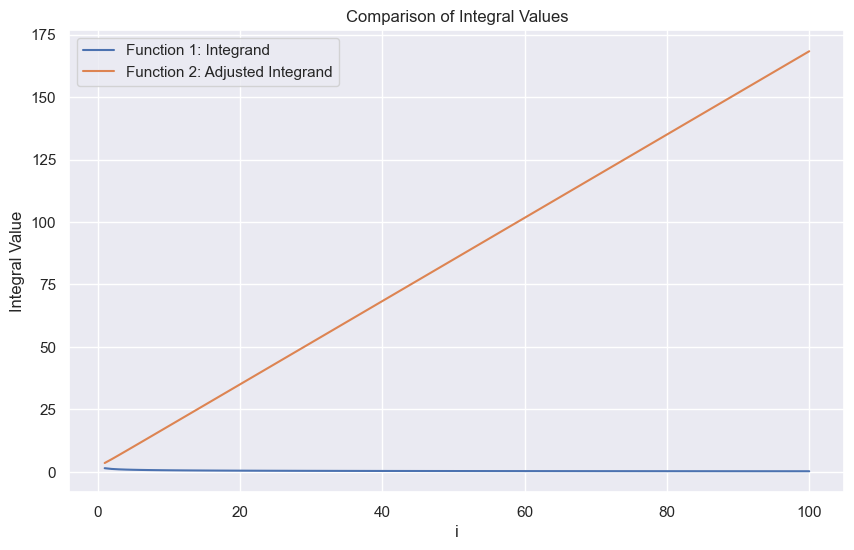

In [4]:
def integrand(v, i, j, alpha):
    """
    Fonction intégrée utilisée pour calculer les coefficients de la matrice B.

    :param v: Float
        La variable d'intégration.

    :param i: Int
        L'indice de ligne pour le coefficient de matrice : 0 <= i <= N-1.

    :param j: Int
        L'indice de colonne pour le coefficient de matrice : 0 <= j <= N-1.

    :param alpha: Float
        Paramètre de forme influençant la dynamique du modèle.

    :return: Float
        Valeur de l'intégrale pour les paramètres donnés.
    """
    return np.power(i + v, alpha, dtype=np.float64) * np.power(j + v, alpha, dtype=np.float64)


def integrand2(v, i, alpha):
    return np.power(i + v, alpha - 1, dtype=np.float64) * np.power(v, alpha + 1, dtype=np.float64)


def calculate_values(alpha):
    I_values = []
    I2_values = []
    i_range = np.arange(1, 101)  # de i = 1 à 100 (le terme de la diagonale, i.e pour i = 0, n'est pas concerne)
    
    for i in i_range:
        # Calcul pour la première fonction
        I = quad(integrand, 0, 1, args=(i, 0, alpha))[0]
        I_values.append(I)
        
        # Calcul pour la seconde fonction
        integral_part = quad(integrand2, 0, 1, args=(i, alpha))[0]
        I2 = ((i + 1) / (alpha + 1)) - ((alpha) / (alpha + 1)) * integral_part
        I2_values.append(I2)
    
    return i_range, I_values, I2_values

# Fixer H
H = 0.1

# Obtenir les valeurs
i_range, I_values, I2_values = calculate_values(H - 1/2)

# Création du graphique
plt.figure(figsize=(10, 6))
plt.plot(i_range, I_values, label='Function 1: Integrand')
plt.plot(i_range, I2_values, label='Function 2: Adjusted Integrand')
plt.title('Comparison of Integral Values')
plt.xlabel('i')
plt.ylabel('Integral Value')
plt.legend()
plt.grid(True)
plt.show()

Après calculs, on se doute qu'il s'agit là d'une erreur de frappe car la véritable formule est donnée par :<br>

<center>$\forall i \geq 1 \quad B_{0i} = B_{i0} = \int_{0}^{1} (i + v)^{\alpha} v^{\alpha} \, dv = \frac{(i + 1)^\alpha}{\alpha + 1} - \frac{\alpha}{\alpha + 1} \int_{0}^{1} (i + v)^{\alpha - 1} v^{\alpha + 1} \, dv$</center>

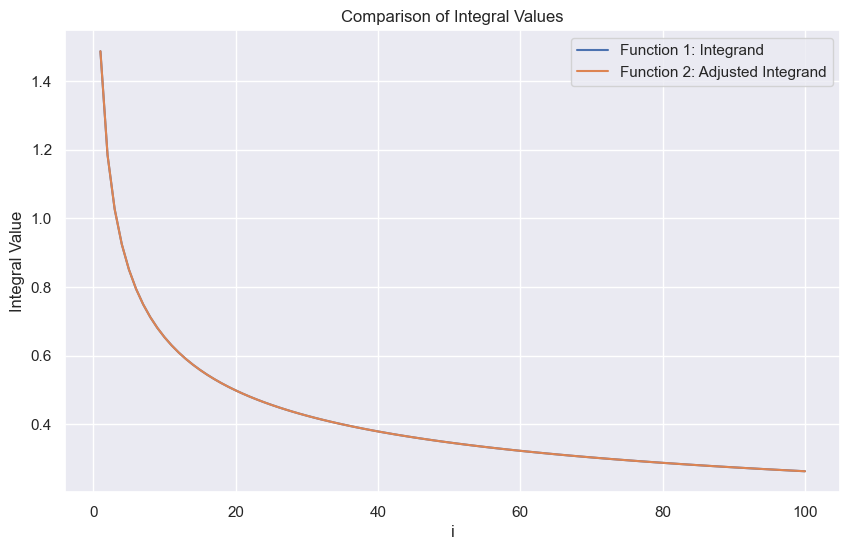

In [5]:
def calculate_values(alpha):
    I_values = []
    I2_values = []
    i_range = np.arange(1, 101)
    
    for i in i_range:
        # Calcul pour la première fonction
        I = quad(integrand, 0, 1, args=(i, 0, alpha))[0]
        I_values.append(I)
        
        # Calcul pour la seconde fonction
        integral_part = quad(integrand2, 0, 1, args=(i, alpha))[0]
        I2 = ((i + 1)**alpha / (alpha + 1)) - ((alpha) / (alpha + 1)) * integral_part
        I2_values.append(I2)
    
    return i_range, I_values, I2_values

# Fixer H
H = 0.1

# Obtenir les valeurs
i_range, I_values, I2_values = calculate_values(H - 1/2)

# Création du graphique
plt.figure(figsize=(10, 6))
plt.plot(i_range, I_values, label='Function 1: Integrand')
plt.plot(i_range, I2_values, label='Function 2: Adjusted Integrand')
plt.title('Comparison of Integral Values')
plt.xlabel('i')
plt.ylabel('Integral Value')
plt.legend()
plt.grid(True)
plt.show()

**Une autre remarque concernant l'implémentation numérique du calcul de la matrice B :**<br>
A cause des erreur d'approximation, la matrice B peut ne pas être exactement semie-définie positive : certaines valeurs propres peuvent être négatives mais extrêmement proches de 0.<br>

Ci-dessous une rapide illustration du phénomène :

In [6]:
def b_ij(i, j, alpha):
    """
    Calcule le coefficient (B_ij) de la matrice B.

    :param i: Int
        L'indice de ligne pour le coefficient de la matrice : 0 <= i <= N-1.

    :param j: Int
        L'indice de colonne pour le coefficient de la matrice : 0 <= j <= N-1.

    :param alpha: Float
        Paramètre de forme qui influence la partie fractionnaire du noyau de convolution.

    :return: Float
        Le coefficient B_ij de la matrice B.
    """
    if i == j:  # Forme fermée
        return (1 / (2*alpha + 1)) * (np.power(i + 1, 2*alpha + 1, dtype=np.float64) - np.power(i, 2*alpha + 1, dtype=np.float64))

    # elif i == 0:
        # return (j + 1)/(alpha + 1) - (alpha/(alpha + 1))*quad(integrand2, 0, 1, args=(j, alpha))[0]

    # elif j == 0:
        # return (i + 1)/(alpha + 1) - (alpha/(alpha + 1))*quad(integrand2, 0, 1, args=(i, alpha))[0]

    else:
        result, error = quad(integrand, 0, 1, args=(i, j, alpha))
        return result

In [7]:
N = 500

H = 0.1

B = np.zeros((N, N))

# Remplissage de la moitié supérieure (diagonale incluse)
with tqdm(range(N), desc="Calcul de la matrice B") as Nrange:
    for i in Nrange:
        for j in range(i, N):
            B[i, j] = b_ij(i, j, H - 1/2)

B = B + B.T - np.diag(np.diag(B))

Calcul de la matrice B: 100%|████████████████| 500/500 [00:02<00:00, 169.26it/s]


In [8]:
(np.linalg.eigh(B)[0] >= -10e-8).all()  # eigh car B est symétrique !!!

np.True_

In [9]:
(np.linalg.eigh(B)[0] > -10e-16).all()

np.False_

Nous reviendrons sur ce phénomène plus en détails par la suite. Néanmoins, après plusieurs essais, la solution la plus robuste pour pallier à ce problème semble être l'ajout d'un epsilon extrêmement faible à la diagonale de la matrice.

**Maintenant, la simulation du modèle :**

In [10]:
# Fonctions intermédiaires
def phi_tilde(t, H):
    """
    Intégrale de 0 à t du co-noyau / pseudo inverse.
    
    :param t: Float
        Le temps pour lequel la transformation est calculée.

    :param H: Float
        Paramètre de Hurst, influençant le degré de mémoire du processus.

    :return: Float
        Valeur de la transformation de temps à l'instant t.
    """
    return np.power(t, 1/2 - H, dtype=np.float64) / gamma_function(3/2 - H)


def b_func(y, mu, lamb):
    """
    Calcule le terme de drift dans le modèle.

    :param y: Float
        La valeur actuelle du processus pour lequel le drift est calculé.

    :param mu: Float
        Le taux de rendement moyen attendu de l'actif.

    :param lamb: Float
        Taux de retour à la moyenne pour le processus.

    :return: Float
        La valeur du drift pour la valeur y du processus.
    """
    return mu - lamb*y


def sigma(y, a, b, c):
    """
    Calcul le terme de dérive dans le modèle.

    :param y: Float
        La valeur actuelle du processus.

    :param a: Float
        Coefficient influençant la dépendance de la volatilité par rapport à l'écart entre y et b.

    :param b: Float
        Valeur autour de laquelle la volatilité est ajustée.

    :param c: Float
        Terme constant assurant que la volatilité ne tombe jamais en dessous d'un certain seuil.

    :return: Float
        La volatilité calculée pour la valeur y.
    """
    return np.sqrt(a*np.power(y-b, 2) + c)


def deterministic_term(l, xi, k, mu, lamb, H, dt):
    """
    Permet de calculer le terme déterministe dans la somme pour simuler le processus éléphant au temps k+1.

    :param l: Int
        Indice de la somme.

    :param xi: Float
        La valeur du processus à l'indice l : 0 <= l <= k.

    :param k: Int
        Indice représentant la fin de l'intervalle temporel pour le calcul.

    :param mu: Float
        Le taux de rendement moyen attendu de l'actif.

    :param lamb: Float
        Taux de retour à la moyenne pour le processus.

    :param H: Float
        Paramètre de Hurst, influençant le degré de mémoire du processus.

    :param dt: Float
        dt = T/N, le pas de temps.

    :return: Float
        La contribution déterministe du terme pour les indices l et k.
    """
    return b_func(xi, mu, lamb)*(np.power(k - l + 1, H + 1/2) - np.power(k - l, H + 1/2))*np.power(dt, H + 1/2)*(1 / (H + 1/2))

In [31]:
def simulate_model(s0, eta, mu, lamb, a, b, c, H, T, xi0, N, size_sample, rho):
    """
    Simule les trajectoires d'un actif financier selon le modèle présenté dans l'article. 
    Ce modèle est particulier dans le sens où la volatilité de l'actif possède un effet de mémoire. 

    :param s0: Float
        Prix initial de l'actif financier.

    :param eta: Float
        Facteur d'échelle pour lisser la volatilité des processus "poisson rouge" et "éléphant".

    :param mu: Float
        Taux de rendement moyen attendu de l'actif.

    :param lamb: Float
        Taux de retour à la moyenne pour le modèle de "poisson rouge".

    :param a: Float
        Coefficient de l'échelle de la variance dans le modèle de l'actif.

    :param b: Float
        Point moyen autour duquel la variance fluctue.

    :param c: Float
        Terme constant ajouté à la variance. Seuil minimal / Variance "planchée"

    :param H: Float
        Paramètre de Hurst, contrôlant le degré de mémoire du processus "éléphant".

    :param T: Float
        Durée totale de la période de simulation, en années.

    :param xi0: Float
        Condition initiale pour le processus "éléphant".

    :param N: Int
        N+1 points de temps pour un pas de T/N.

    :param size_sample: Int
        Nombre de trajectoires indépendantes à simuler.

    :param rho: Float
        Taux de corrélation entre les mouvements browniens guidant les processus modélisant l'actif financier et la volatilité.

    :return: tuple of np.arrays
        Renvoie quatre matrices N+1 x size_sample pour Y, Z, V, et S représentant respectivement :
        - Y : le processus 'poisson rouge' markovien
        - Z : le processus 'éléphant' non-markovien
        - V : la variance du processus
        - S : le prix de l'actif financier simulé
    """
    dt = T/N

    # -------- Construction de la matrice G pour la simulation des processus --------
    # Calcul de la matrice [B_int]1<=i,j<=N
    B_int = np.zeros((N, N))
    
    # Remplissage de la moitié supérieure (diagonale incluse)
    with tqdm(range(N), desc="Calcul de la matrice B_int") as Nrange:
        for i in Nrange:
            for j in range(i, N):
                B_int[i, j] = b_ij(i, j, H - 1/2)
    
    B_int = B_int + B_int.T - np.diag(np.diag(B_int))

    # On s'assure que la matrice B_int est semi définie positive en gommant les erreur numériques
    B_int = B_int + (10e-9) * np.eye(N)

    print("Décomposition de Cholesky de la matrice B_int")
    # Decomposition de Cholesky de la matrice B_int
    try:
        L_B_int = np.linalg.cholesky(B_int)
    except np.linalg.LinAlgError as e:
        print("Erreur lors du calcul de la décomposition de Cholesky de la matrice B_int:", str(e))
        raise ValueError  # Ne devrait pas arriver, la matrice est semie définie positive...

    # Calcul du vecteur V
    t = np.arange(N)
    V = np.power(T/N, H + 1/2) * (1 / (H + 1/2)) * ((t + 1)**(H + 1/2) - t**(H + 1/2))

    # Calcul du vecteur U
    U = rho * V

    # Calcul de la matrice K
    K = np.array([[T/N, rho * T/N], 
                  [rho * T/N, T/N]])   

    # -------- Construction des N colonnes de G --------
    list_G = []  # Une matrice G par trajectoire
    with tqdm(range(size_sample), desc="Calcul des matrices G") as range_num_traj:
        for num_traj in range_num_traj:
            G_traj = np.zeros((N+2, N))
            for l in range(1, N+1):
                # Décomposition de Cholesky de la sous matrice B_l
                L_B_int_l = L_B_int[:N-l+1, :N-l+1]
                L_B_l = np.power(dt, H) * L_B_int_l
    
                # Sous vecteur V_l
                V_l = V[:N-l+1]
                V_l = V_l.reshape(N-l+1, 1)
    
                # Sous vecteur U_l
                U_l = U[:N-l+1]
                U_l = U_l.reshape(N-l+1, 1)
    
                # Sous matrice
                s_l = np.hstack((V_l, U_l))
    
                # Décomposition de Cholesky de la matrice de covariance globale Sigma_l
                delta_l = np.linalg.solve(L_B_l, s_l)
                # print(f"l = {l}\n{delta_l[:,0]}\n{delta_l[:,1]}\n")
    
                Temp = K - np.transpose(delta_l) @ delta_l
                # On s'assure que la matrice Temp est semi définie positive en gommant les erreur numériques
                Temp = Temp + (10e-9) * np.eye(2)
                try:
                    M = np.linalg.cholesky(Temp)
                except np.linalg.LinAlgError as e:
                    print("Erreur lors du calcul de la décomposition de Cholesky de la matrice K - (delta_l)^T * delta_l :", str(e))
                    raise ValueError  # Ne devrait pas arriver, la matrice est semie définie positive...
                    
                # Initialisation de la matrice L_l
                L_l = np.zeros((N-l+3, N-l+3))
                L_l[:N-l+1, :N-l+1] = L_B_l
                
                # Ajout de delta_l dans L_l
                delta_l_t = np.transpose(delta_l)
                L_l[N-l+1:N-l+3, :N-l+1] = delta_l_t
                
                # Ajout de M dans L_l
                L_l[N-l+1:N-l+3, N-l+1:N-l+3] = M
                # print(f"L_l =\n{L_l}\n")

                # Accroissements browniens
                w_acc = rng.standard_normal(size=(N-l+3, 1))
                
                # l-ième colonne de G simulée
                G_traj[l-1:N+2, l-1] = (L_l @ w_acc)[:, 0]
    
            list_G.append(G_traj)
            # print(f"G_traj[N, :] = {G_traj[N, :]}")
            # print(f"G_traj[N+1, :] = {G_traj[N+1, :]}")
            
    # -------- Simulation des processus --------
    Y = np.zeros(shape=(N+1, size_sample))  # Le processus commence en 0, donc N browniens pour une trajectoire de N+1 points
    Z = np.zeros(shape=(N+1, size_sample))
    Z[0, :] = xi0
    V = np.zeros(shape=(N+1, size_sample))
    V[0, :] = a*(xi0 - b)**2 + c
    S = np.zeros(shape=(N+1, size_sample))
    S[0, :] = s0
    with tqdm(range(1, N+1), desc="Simulation des trajectoires") as Nrange:
        for n in Nrange:
            for num_traj in range(size_sample):
                G_traj = list_G[num_traj]

                # Simulation du processus markovien "poisson rouge"
                Y[n][num_traj] = Y[n-1][num_traj] + xi0*(1/gamma_function(3/2 - H))*(np.power(n*dt, 1/2 - H) - np.power((n-1)*dt, 1/2 - H)) + dt*b_func(Y[n-1][num_traj], mu, lamb) + eta*sigma(Y[n-1][num_traj], a, b, c)* G_traj[N, n-1]
                # print(f"G_traj[{N}, {n}-1] : {G_traj[N, n-1]}")
                
                # Simulation du processus "elephant"
                Z[n][num_traj] = xi0
        
                # Calcul de la somme
                l = np.arange(n)
    
                # Premier terme déterministe
                vectorized_deterministic_term = np.vectorize(lambda v1, v2: deterministic_term(v1, v2, n, mu, lamb, H, dt))
                xi = Y[:n, num_traj]
                s1 = vectorized_deterministic_term(l, xi)
    
                # Second terme stochastique
                s2 = eta * sigma(xi, a, b, c) * G_traj[n-1, :n]

                print(len(s1) == len(s2))
                print(f"len(s1) = {len(s1)}, len(s2) = {len(s2)}, len(G_traj[n-1, :n]) = {len(G_traj[n-1, :n])}, n = {n}\n")                
                
                Z[n][num_traj] += np.sum(s1 +s2)*(1 / gamma_function(H + 1/2))
                # print(f"num_traj = {num_traj}\nn = {n}\nxi = {xi}\nG_traj[n-1, :n] = {G_traj[n-1, :n]}\n")

                # Simulation du processus de Variance
                V[n][num_traj] = a*np.power(Z[n][num_traj] - b, 2) + c
    
                # Simulation de l'actif financier
                S[n][num_traj] = S[n-1][num_traj] + S[n-1][num_traj]*np.sqrt(V[n-1][num_traj])*G_traj[N+1, n-1]
                # print(f"G_traj[{N+1}, {n}-1] : {G_traj[N+1, n-1]}")

    
    return Y, Z, V, S

**Quelques remarques sur le code :**
* On profite de la propriété de symétrie de la matrice C pour réduire sa complexité de calcul.

* On profite du fait que si une matrice définie positive $A$ peut s'écrire sous la forme factorisée $A = \lambda * B$ avec $\lambda$ un scalaire, alors   la décomposition de $A$ peut s'écrire sous la forme : $A = \sqrt{\lambda} L_B (\sqrt{\lambda} L_B)^T$ avec $L_B$ la décomposition de Cholesky de B.<br>
  Effectuer cette multiplication une fois la décomposition de Cholesky effectuée permet de limiter l'erreur numérique.

In [32]:
# Paramètres de la simulation
# Globaux
s0 = 1           # Prix initial de l'actif
T = 5            # Maturité / Temps d'arrêt de la simulation
N = 8         # N+1 points de discrétisations de l'intervalle [0, T]
size_sample = 5  # Nombre de trajectoires à générer

H = 0.1  # Paramètre de Hurst

# Paramètres de la fonction sigma
a = 0.384
b = 0.095
c = 0.0025

# Taux de corrélation des browniens
rho = -0.7

times = np.linspace(start=0, stop=T, num=N+1)  # Discrétisation de [0, T] en N+1 points, pas de T/N

Calcul de la matrice B_int: 100%|████████████████| 8/8 [00:00<00:00, 875.93it/s]


Décomposition de Cholesky de la matrice B_int


Simulation des trajectoires: 100%|██████████████| 8/8 [00:00<00:00, 3710.54it/s]


True
len(s1) = 1, len(s2) = 1, len(G_traj[n-1, :n]) = 1, n = 1

True
len(s1) = 1, len(s2) = 1, len(G_traj[n-1, :n]) = 1, n = 1

True
len(s1) = 1, len(s2) = 1, len(G_traj[n-1, :n]) = 1, n = 1

True
len(s1) = 1, len(s2) = 1, len(G_traj[n-1, :n]) = 1, n = 1

True
len(s1) = 1, len(s2) = 1, len(G_traj[n-1, :n]) = 1, n = 1

True
len(s1) = 2, len(s2) = 2, len(G_traj[n-1, :n]) = 2, n = 2

True
len(s1) = 2, len(s2) = 2, len(G_traj[n-1, :n]) = 2, n = 2

True
len(s1) = 2, len(s2) = 2, len(G_traj[n-1, :n]) = 2, n = 2

True
len(s1) = 2, len(s2) = 2, len(G_traj[n-1, :n]) = 2, n = 2

True
len(s1) = 2, len(s2) = 2, len(G_traj[n-1, :n]) = 2, n = 2

True
len(s1) = 3, len(s2) = 3, len(G_traj[n-1, :n]) = 3, n = 3

True
len(s1) = 3, len(s2) = 3, len(G_traj[n-1, :n]) = 3, n = 3

True
len(s1) = 3, len(s2) = 3, len(G_traj[n-1, :n]) = 3, n = 3

True
len(s1) = 3, len(s2) = 3, len(G_traj[n-1, :n]) = 3, n = 3

True
len(s1) = 3, len(s2) = 3, len(G_traj[n-1, :n]) = 3, n = 3

True
len(s1) = 4, len(s2) = 4, len(G_tra

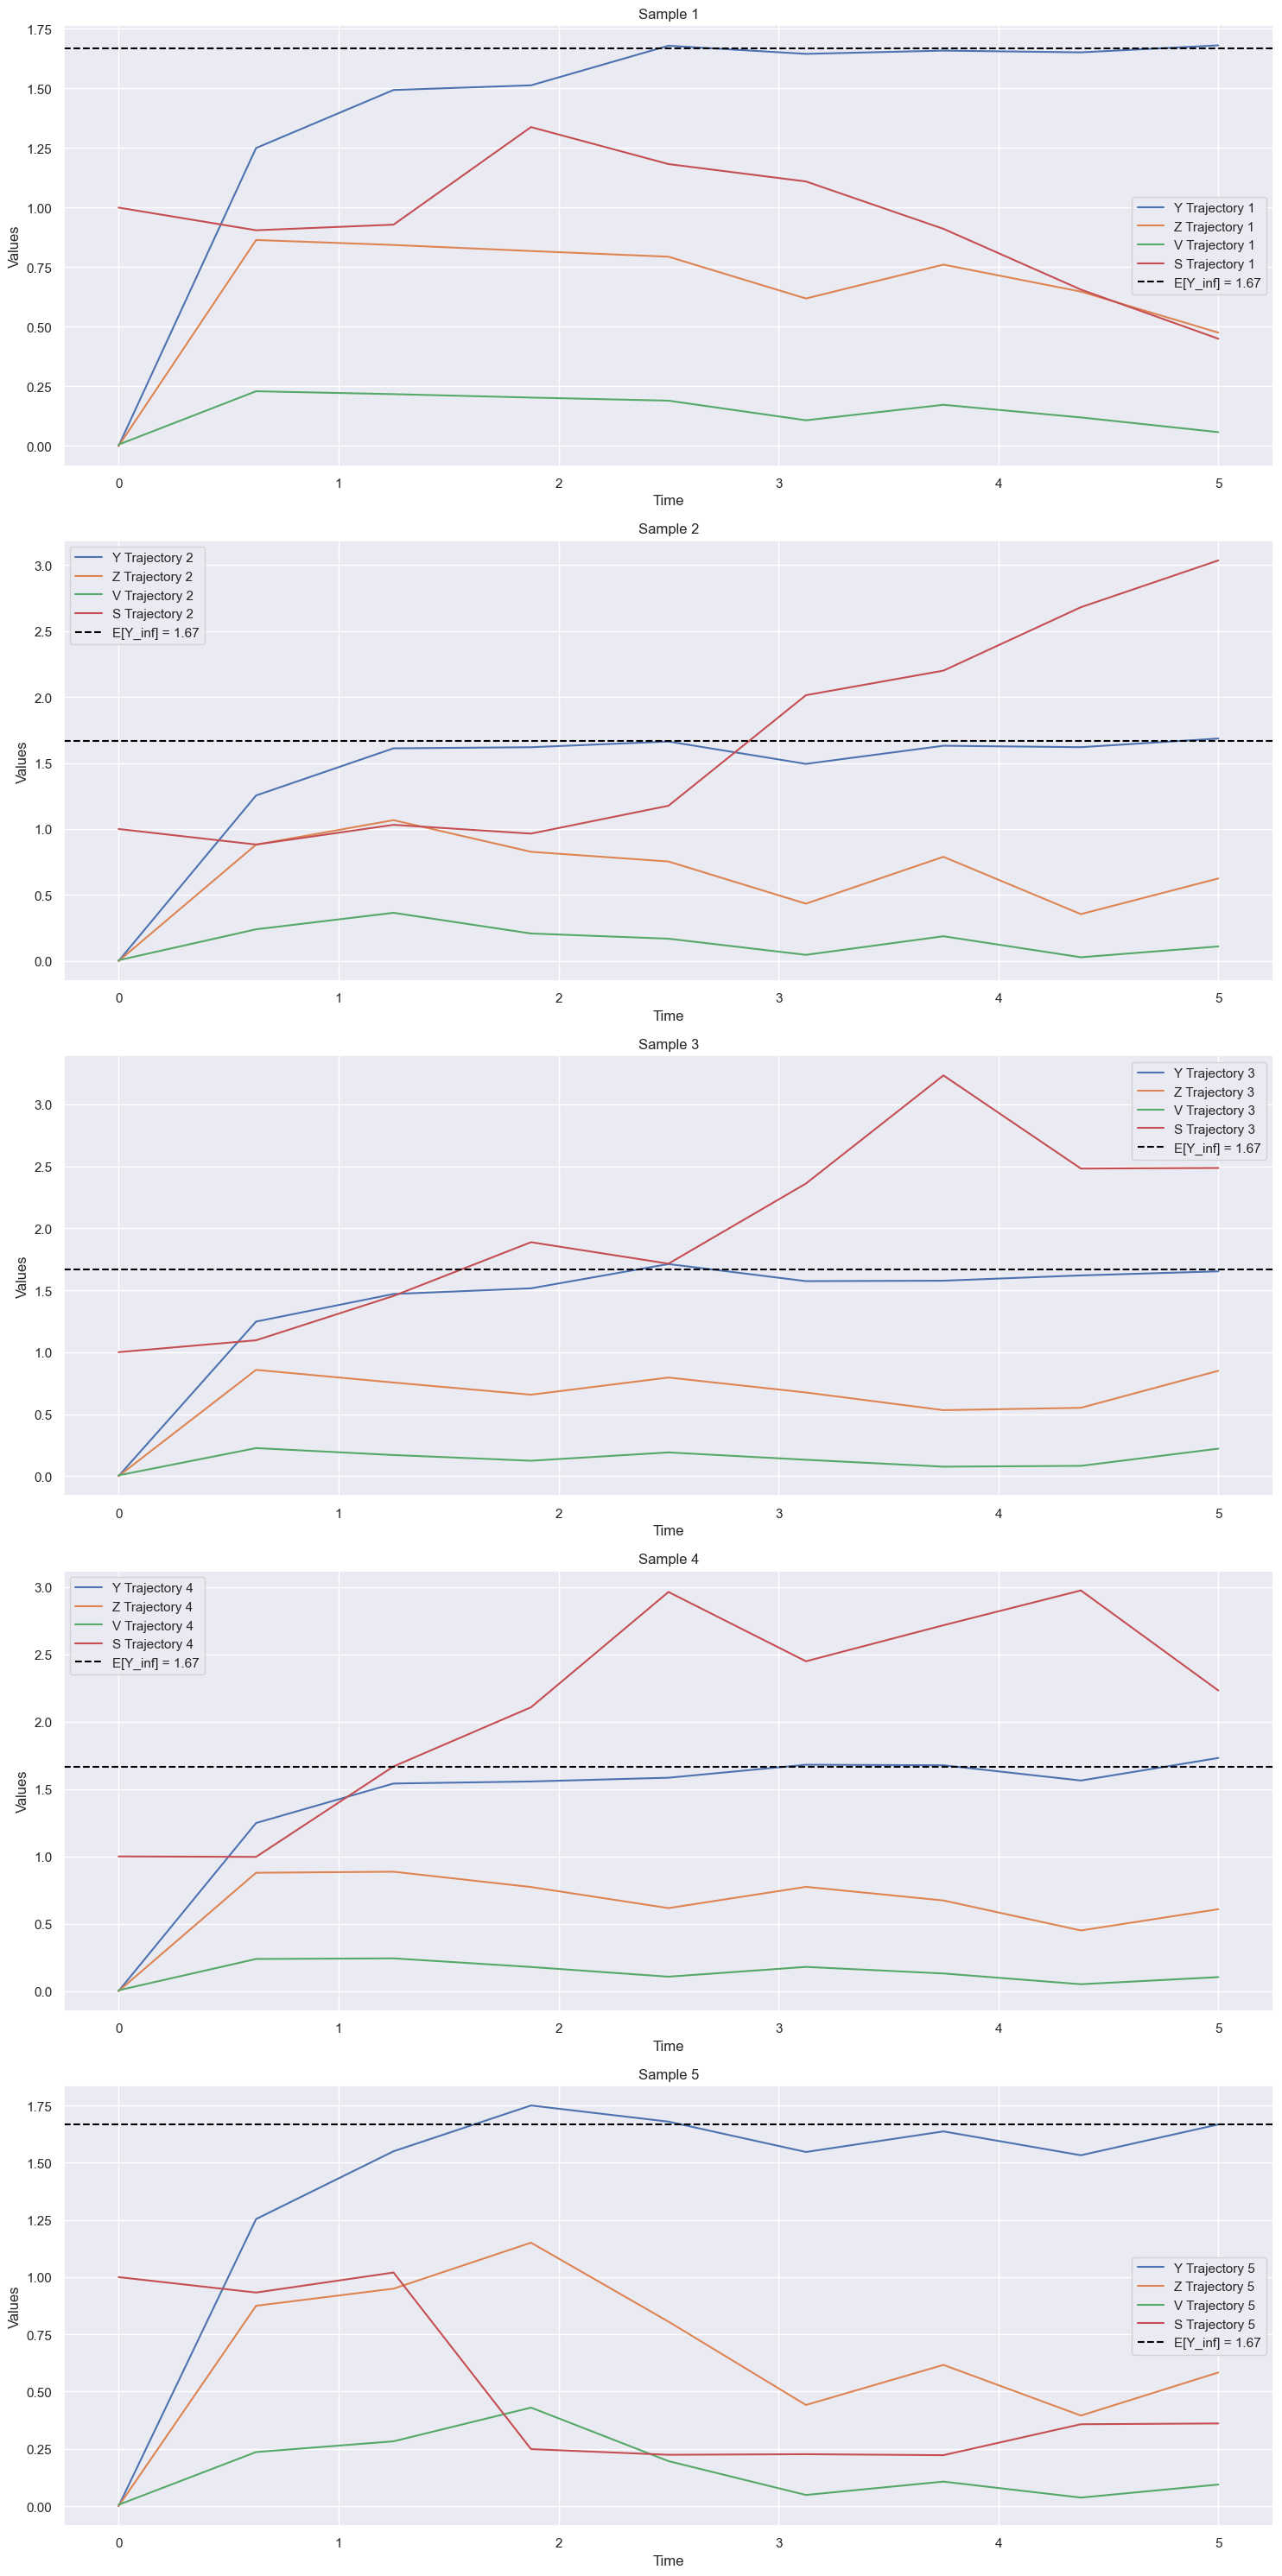

In [33]:
# Première simulation
eta = 0.1

# Paramètres de la fonction b
mu = 2
lamb = 1.2

# Processus markovien poisson rouge Y
xi0 = 0

Y, Z, V, S = simulate_model(s0, eta, mu, lamb, a, b, c, H, T, xi0, N, size_sample, rho)

plt.figure(figsize=(15, 6 * size_sample))
for i in range(size_sample):
    plt.subplot(size_sample, 1, i + 1)
    plt.plot(times, Y[:, i], label=f"Y Trajectory {i+1}")
    plt.plot(times, Z[:, i], label=f"Z Trajectory {i+1}")
    plt.plot(times, V[:, i], label=f"V Trajectory {i+1}")
    plt.plot(times, S[:, i], label=f"S Trajectory {i+1}")
    plt.axhline(y=mu/lamb, color="black", linestyle="--", label=f"E[Y_inf] = {mu/lamb:.2f}")
    plt.title(f"Sample {i+1}")
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.legend()

plt.tight_layout()
plt.show()

In [15]:
Y

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [1.2491258 , 1.2449832 , 1.25784829, 1.25547462, 1.24404594],
       [1.5884482 , 1.61009829, 1.62098163, 1.52984405, 1.60919543],
       [1.54106896, 1.49252465, 1.70561465, 1.7167786 , 1.65300027],
       [1.61519282, 1.5796424 , 1.61358802, 1.80856195, 1.7234492 ],
       [1.64497983, 1.53150123, 1.5739761 , 1.58566768, 1.73060891],
       [1.73161274, 1.64598495, 1.54446089, 1.57402086, 1.80625606],
       [1.61692045, 1.68211388, 1.6386865 , 1.64293558, 1.64372527],
       [1.63775895, 1.71775187, 1.66603407, 1.60651992, 1.63633693]])

In [ ]:
# Deuxième simulation
eta = 0.1

# Paramètres de la fonction b
mu = 2
lamb = 1.2

# Processus markovien poisson rouge Y
xi0 = mu/lamb

Y, Z, V, S = simulate_model(s0, eta, mu, lamb, a, b, c, H, T, xi0, N, size_sample, rho)

plt.figure(figsize=(15, 6 * size_sample))
for i in range(size_sample):
    plt.subplot(size_sample, 1, i + 1)
    plt.plot(times, Y[:, i], label=f'Y Trajectory {i+1}')
    plt.plot(times, Z[:, i], label=f'Z Trajectory {i+1}')
    plt.plot(times, V[:, i], label=f'V Trajectory {i+1}')
    plt.plot(times, S[:, i], label=f'S Trajectory {i+1}')
    plt.axhline(y=mu/lamb, color="black", linestyle="--", label=f"E[Y_inf] = {mu/lamb:.2f}")
    plt.title(f"Sample {i+1}")
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Troisième simulation
eta = 0.01

# Paramètres de la fonction b
mu = 2
lamb = 20

# Processus markovien poisson rouge Y
xi0 = mu/lamb

Y, Z, V, S = simulate_model(s0, eta, mu, lamb, a, b, c, H, T, xi0, N, size_sample, rho)

plt.figure(figsize=(15, 6 * size_sample))
for i in range(size_sample):
    plt.subplot(size_sample, 1, i + 1)
    plt.plot(times, Y[:, i], label=f'Y Trajectory {i+1}')
    plt.plot(times, Z[:, i], label=f'Z Trajectory {i+1}')
    plt.plot(times, V[:, i], label=f'V Trajectory {i+1}')
    plt.plot(times, S[:, i], label=f'S Trajectory {i+1}')
    plt.axhline(y=mu/lamb, color="black", linestyle="--", label=f"E[Y_inf] = {mu/lamb:.2f}")
    plt.title(f"Sample {i+1}")
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.legend()

plt.tight_layout()
plt.show()

### Nouvelle approche la correction des erreurs numériques

Comme énoncé précedemment, à cause des erreurs d'approximation numériques, certaines matrices qui devraient être semi-définies positives se retrouvent à avoir des valeurs propres négatives très proches de 0 (de l'ordre de $-10^{-8}$ à $-10^{-22}$).<br>
La solution la plus robuste pour pallier à ce problème est d'ajouter un espilon très faible (de l'ordre de l'erreur d'approximation) à la diagonale de la matrice.

Une autre approche consiste à effectuer une décomposition de la matrice en éléments propres, à identifier les valeurs propres négatives, à les remplacer par un epsilon positif très proche de 0, puis à reconstruire la matrice avec les nouvelles valeurs propres.<br>
Après plusieurs tentatives d'implémentation, il apparait clairement que les mauvais conditionnement des matrices "B_int" et "Temp" rendent les caluls extrêmement instables.
En effet, en comparant la similaraité des matrices originales et reconstruites avec les nouvelles valeurs popres à l'aide de la norme de Frobenius, nous pouvons observer un écart significatif.

L'implémentation suivante est donc laissée à titre d'exemple mais devrait pas être utilisée.

In [15]:
def simulate_model_v2(s0, eta, mu, lamb, a, b, c, H, T, xi0, N, size_sample, rho):
    """
    Simule les trajectoires d'un actif financier selon le modèle présenté dans l'article. 
    Ce modèle est particulier dans le sens où la volatilité de l'actif possède un effet de mémoire. 

    :param s0: Float
        Prix initial de l'actif financier.

    :param eta: Float
        Facteur d'échelle pour lisser la volatilité des processus "poisson rouge" et "éléphant".

    :param mu: Float
        Taux de rendement moyen attendu de l'actif.

    :param lamb: Float
        Taux de retour à la moyenne pour le modèle de "poisson rouge".

    :param a: Float
        Coefficient de l'échelle de la variance dans le modèle de l'actif.

    :param b: Float
        Point moyen autour duquel la variance fluctue.

    :param c: Float
        Terme constant ajouté à la variance. Seuil minimal / Variance "planchée"

    :param H: Float
        Paramètre de Hurst, contrôlant le degré de mémoire du processus "éléphant".

    :param T: Float
        Durée totale de la période de simulation, en années.

    :param xi0: Float
        Condition initiale pour le processus "éléphant".

    :param N: Int
        N+1 points de temps pour un pas de T/N.

    :param size_sample: Int
        Nombre de trajectoires indépendantes à simuler.

    :param rho: Float
        Taux de corrélation entre les mouvements browniens guidant les processus modélisant l'actif financier et la volatilité.

    :return: tuple of np.arrays
        Renvoie quatre matrices N+1 x size_sample pour Y, Z, V, et S représentant respectivement :
        - Y : le processus 'poisson rouge' markovien
        - Z : le processus 'éléphant' non-markovien
        - V : la variance du processus
        - S : le prix de l'actif financier simulé
    """
    dt = T/N

    # -------- Construction de la matrice G pour la simulation des processus --------
    # Calcul de la matrice [B_int]1<=i,j<=N
    B_int = np.zeros((N, N))
    
    # Remplissage de la moitié supérieure (diagonale incluse)
    with tqdm(range(N), desc="Calcul de la matrice B_int") as Nrange:
        for i in Nrange:
            for j in range(i, N):
                B_int[i, j] = b_ij(i, j, H - 1/2)
    
    B_int = (B_int + B_int.T - np.diag(np.diag(B_int))).astype(np.float64)

    # B_int *= 10e6
    # B_int = B_int + (10e-9) * np.eye(N)
    # print(f"Nombre de condition de la matrice B_int : {np.linalg.cond(B_int)}")

    # On s'assure que la matrice B_int est semi définie positive en gommant les erreur numériques
    # Calcul des valeurs propres et des vecteurs propres
    valeurs_propres, vecteurs_propres = np.linalg.eigh(B_int)
    # On rempalce les valeurs propres négatives ou nulles par une valeur arbitrairement faible
    valeurs_propres = np.real(valeurs_propres).astype(np.float64)
    valeurs_propres[valeurs_propres <= 0] = 10e-6
    vecteurs_propres = np.real(vecteurs_propres).astype(np.float64)
    # Création de la matrice diagonale V contenant les valeurs propres
    mat_vp = np.diag(valeurs_propres).astype(np.float64)
    # Vérification de la décomposition A = Q * V * Q^(-1)
    # B_int = vecteurs_propres @ mat_vp @ np.linalg.inv(vecteurs_propres)
    B_int_new = vecteurs_propres @ np.linalg.solve(vecteurs_propres, mat_vp)

    # On vérifie à quel point la matrices recosntruite est similaire à l'ancienne
    print(f"Norme de Frobenius de la différence entre B_int et B_int_new : {np.linalg.norm(B_int-B_int_new, 'fro')}")
    B_int = B_int_new

    #print(f"mat_vp = {(mat_vp >= 0).all()}, valeurs propres B_int = {(linalg.eig(B_int)[0] >= 0).all()}")
    # valp, vectp = np.linalg.eig(B_int)
    #print(f"mat_vp = {mat_vp}, valeurs propres B_int = {valp}, vecteurs propres = {vectp}")
    #print(f"B_int.shape = {B_int.shape}")

    # print(f"Nombre de condition de la matrice B_int v2 : {np.linalg.cond(B_int)}")

    print("Décomposition de Cholesky de la matrice B_int")
    # Decomposition de Cholesky de la matrice B_int
    try:
        L_B_int = np.linalg.cholesky(B_int)
    except np.linalg.LinAlgError as e:
        print("Erreur lors du calcul de la décomposition de Cholesky de la matrice B_int:", str(e))
        raise ValueError  # Ne devrait pas arriver, la matrice est semie définie positive...

    # B_int *= 10e-3

    # Calcul du vecteur V
    t = np.arange(N)
    V = np.power(T/N, H + 1/2) * (1 / (H + 1/2)) * ((t + 1)**(H + 1/2) - t**(H + 1/2))

    # Calcul du vecteur U
    U = rho * V

    # Calcul de la matrice K
    K = np.array([[T/N, rho * T/N], 
                  [rho * T/N, T/N]])   

    # -------- Construction des N colonnes de G --------
    list_G = []  # Une matrice G par trajectoire
    with tqdm(range(size_sample), desc="Calcul des matrices G") as range_num_traj:
        for num_traj in range_num_traj:
            G_traj = np.zeros((N+2, N))
            for l in range(1, N+1):
                # Décomposition de Cholesky de la sous matrice B_l
                L_B_int_l = L_B_int[:N-l+1, :N-l+1]
                L_B_l = np.power(dt, H) * L_B_int_l
    
                # Sous vecteur V_l
                V_l = V[:N-l+1]
                V_l = V_l.reshape(N-l+1, 1)
    
                # Sous vecteur U_l
                U_l = U[:N-l+1]
                U_l = U_l.reshape(N-l+1, 1)
    
                # Sous matrice
                s_l = np.hstack((V_l, U_l))
    
                # Décomposition de Cholesky de la matrice de covariance globale Sigma_l
                # print(f"Nombre de condition de la matrice L_B_l : {np.linalg.cond(L_B_l)}")
                # print(f"Nombre de condition de la matrice s_l : {np.linalg.cond(s_l)}")
                
                delta_l = np.linalg.solve(L_B_l, s_l).astype(np.float64)
                # print(f"l = {l}\n{delta_l[:,0]}\n{delta_l[:,1]}\n")
    
                Temp = (K - np.transpose(delta_l) @ delta_l).astype(np.float64)

                # Temp = Temp + (10e-9) * np.eye(2)

                # cond = np.linalg.cond(Temp)
                # print(f"Nombre de condition de la matrice Temp : {cond}")
                # if cond < 10e4 or cond > 10e14 :
                    # print(Temp)

                # print(f"Temp.shape = {Temp.shape}")
                # On s'assure que la matrice Temp est semi définie positive en gommant les erreur numériques
                # Calcul des valeurs propres et des vecteurs propres
                valeurs_propres, vecteurs_propres = np.linalg.eig(Temp)
                # On rempalce les valeurs propres négatives ou nulles par une valeur arbitrairement faible
                valeurs_propres = np.real(valeurs_propres).astype(np.float64)
                valeurs_propres[valeurs_propres <= 0] = 10e-6
                vecteurs_propres = np.real(vecteurs_propres).astype(np.float64)
                # Création de la matrice diagonale V contenant les valeurs propres
                mat_vp = np.diag(valeurs_propres).astype(np.float64)
                vecteurs_propres = vecteurs_propres.astype(np.float64)
                #print(f"vecteurs propres = {vecteurs_propres}")
                # Vérification de la décomposition A = Q * V * Q^(-1)
                Temp_new = vecteurs_propres @ np.linalg.solve(vecteurs_propres, mat_vp)
                # print(f"Temp.shape = {Temp.shape}")
                # print(Temp)

                # On vérifie à quel point la matrices recosntruite est similaire à l'ancienne
                print(f"Norme de Frobenius de la différence entre Temp et Temp_new : {np.linalg.norm(Temp-Temp_new, 'fro')}")
                Temp = Temp_new

                # cond = np.linalg.cond(Temp)
                # print(f"Nombre de condition de la matrice Temp v2 : {cond}")
                # if cond < 10e4 or cond > 10e14 :
                    # print(Temp)  
                    
                try:
                    M = np.linalg.cholesky(Temp)
                except np.linalg.LinAlgError as e:
                    print("Erreur lors du calcul de la décomposition de Cholesky de la matrice K - (delta_l)^T * delta_l :", str(e))
                    raise ValueError  # Ne devrait pas arriver, la matrice est semie définie positive...
                    
                # Initialisation de la matrice L_l
                L_l = np.zeros((N-l+3, N-l+3))
                L_l[:N-l+1, :N-l+1] = L_B_l
                
                # Ajout de delta_l dans L_l
                delta_l_t = np.transpose(delta_l)
                L_l[N-l+1:N-l+3, :N-l+1] = delta_l_t
                
                # Ajout de M dans L_l
                L_l[N-l+1:N-l+3, N-l+1:N-l+3] = M
                # print(f"L_l =\n{L_l}\n")

                # Accroissements browniens
                w_acc = rng.standard_normal(size=(N-l+3, 1))
                
                # l-ième colonne de G simulée
                G_traj[l-1:N+2, l-1] = (L_l @ w_acc)[:, 0]
    
            list_G.append(G_traj)
            # print(f"G_traj[N, :] = {G_traj[N, :]}")
            # print(f"G_traj[N+1, :] = {G_traj[N+1, :]}")
            
    # -------- Simulation des processus --------
    Y = np.zeros(shape=(N+1, size_sample))  # Le processus commence en 0, donc N browniens pour une trajectoire de N+1 points
    Z = np.zeros(shape=(N+1, size_sample))
    Z[0, :] = xi0
    V = np.zeros(shape=(N+1, size_sample))
    V[0, :] = a*(xi0 - b)**2 + c
    S = np.zeros(shape=(N+1, size_sample))
    S[0, :] = s0
    with tqdm(range(1, N+1), desc="Simulation des trajectoires") as Nrange:
        for n in Nrange:
            for num_traj in range(size_sample):
                G_traj = list_G[num_traj]

                # Simulation du processus markovien "poisson rouge"
                Y[n][num_traj] = Y[n-1][num_traj] + xi0*(1/gamma_function(3/2 - H))*(np.power(n*dt, 1/2 - H) - np.power((n-1)*dt, 1/2 - H)) + dt*b_func(Y[n-1][num_traj], mu, lamb) + eta*sigma(Y[n-1][num_traj], a, b, c)* G_traj[N, n-1]
                # print(f"G_traj[{N}, {n}-1] : {G_traj[N, n-1]}")
                
                # Simulation du processus "elephant"
                Z[n][num_traj] = xi0
        
                # Calcul de la somme
                l = np.arange(n)
    
                # Premier terme déterministe
                vectorized_deterministic_term = np.vectorize(lambda v1, v2: deterministic_term(v1, v2, n, mu, lamb, H, dt))
                xi = Y[:n, num_traj]
                s1 = vectorized_deterministic_term(l, xi)
    
                # Second terme stochastique
                s2 = eta * sigma(xi, a, b, c) * G_traj[n-1, :n]
                
                Z[n][num_traj] += np.sum(s1 +s2)*(1 / gamma_function(H + 1/2))
                # print(f"num_traj = {num_traj}\nn = {n}\nxi = {xi}\nG_traj[n-1, :n] = {G_traj[n-1, :n]}\n")

                # Simulation du processus de Variance
                V[n][num_traj] = a*np.power(Z[n][num_traj] - b, 2) + c
    
                # Simulation de l'actif financier
                S[n][num_traj] = S[n-1][num_traj] + S[n-1][num_traj]*np.sqrt(V[n-1][num_traj])*G_traj[N+1, n-1]
                # print(f"G_traj[{N+1}, {n}-1] : {G_traj[N+1, n-1]}")

    
    return Y, Z, V, S

Calcul de la matrice B_int: 100%|██████████| 500/500 [00:05<00:00, 85.49it/s] 


Norme de Frobenius de la différence entre B_int et B_int_new : 22.177515050555872
Décomposition de Cholesky de la matrice B_int


Calcul des matrices G:   0%|          | 0/5 [00:00<?, ?it/s]

Norme de Frobenius de la différence entre Temp et Temp_new : 309463419580976.5
Norme de Frobenius de la différence entre Temp et Temp_new : 309463419580976.5
Norme de Frobenius de la différence entre Temp et Temp_new : 309463419580976.5
Norme de Frobenius de la différence entre Temp et Temp_new : 309463419580976.5
Norme de Frobenius de la différence entre Temp et Temp_new : 309463419580956.0
Norme de Frobenius de la différence entre Temp et Temp_new : 309463419556538.8
Norme de Frobenius de la différence entre Temp et Temp_new : 309463376179801.75
Norme de Frobenius de la différence entre Temp et Temp_new : 309437171168609.9
Norme de Frobenius de la différence entre Temp et Temp_new : 309404984368216.8
Norme de Frobenius de la différence entre Temp et Temp_new : 309366960000609.6
Norme de Frobenius de la différence entre Temp et Temp_new : 309326880723629.06
Norme de Frobenius de la différence entre Temp et Temp_new : 309281064960384.06
Norme de Frobenius de la différence entre Temp et

Calcul des matrices G:  20%|██        | 1/5 [00:02<00:10,  2.63s/it]

Norme de Frobenius de la différence entre Temp et Temp_new : 12335.953235309707
Norme de Frobenius de la différence entre Temp et Temp_new : 12258.82123281783
Norme de Frobenius de la différence entre Temp et Temp_new : 12180.13086373447
Norme de Frobenius de la différence entre Temp et Temp_new : 12099.80944723478
Norme de Frobenius de la différence entre Temp et Temp_new : 12017.778888948114
Norme de Frobenius de la différence entre Temp et Temp_new : 11933.955118739657
Norme de Frobenius de la différence entre Temp et Temp_new : 11848.247452660775
Norme de Frobenius de la différence entre Temp et Temp_new : 11760.557866351079
Norme de Frobenius de la différence entre Temp et Temp_new : 11670.7801646001
Norme de Frobenius de la différence entre Temp et Temp_new : 11578.799028585108
Norme de Frobenius de la différence entre Temp et Temp_new : 11484.488918321676
Norme de Frobenius de la différence entre Temp et Temp_new : 11387.71280286886
Norme de Frobenius de la différence entre Temp

Calcul des matrices G:  40%|████      | 2/5 [00:05<00:08,  2.67s/it]

Norme de Frobenius de la différence entre Temp et Temp_new : 14392.877904902436
Norme de Frobenius de la différence entre Temp et Temp_new : 14346.014670149914
Norme de Frobenius de la différence entre Temp et Temp_new : 14298.648867426191
Norme de Frobenius de la différence entre Temp et Temp_new : 14250.768205155262
Norme de Frobenius de la différence entre Temp et Temp_new : 14202.359917678514
Norme de Frobenius de la différence entre Temp et Temp_new : 14153.410740092055
Norme de Frobenius de la différence entre Temp et Temp_new : 14103.906881373103
Norme de Frobenius de la différence entre Temp et Temp_new : 14053.833995652833
Norme de Frobenius de la différence entre Temp et Temp_new : 14003.177151478996
Norme de Frobenius de la différence entre Temp et Temp_new : 13951.920798895746
Norme de Frobenius de la différence entre Temp et Temp_new : 13900.048734150638
Norme de Frobenius de la différence entre Temp et Temp_new : 13847.544061818902
Norme de Frobenius de la différence entr

Calcul des matrices G:  60%|██████    | 3/5 [00:07<00:05,  2.65s/it]

Norme de Frobenius de la différence entre Temp et Temp_new : 15122.685032543539
Norme de Frobenius de la différence entre Temp et Temp_new : 15082.849075908358
Norme de Frobenius de la différence entre Temp et Temp_new : 15042.66520093279
Norme de Frobenius de la différence entre Temp et Temp_new : 15002.126495141678
Norme de Frobenius de la différence entre Temp et Temp_new : 14961.225830036801
Norme de Frobenius de la différence entre Temp et Temp_new : 14919.95585183134
Norme de Frobenius de la différence entre Temp et Temp_new : 14878.308971676594
Norme de Frobenius de la différence entre Temp et Temp_new : 14836.277355346956
Norme de Frobenius de la différence entre Temp et Temp_new : 14793.852912346447
Norme de Frobenius de la différence entre Temp et Temp_new : 14751.027284397142
Norme de Frobenius de la différence entre Temp et Temp_new : 14707.79183326658
Norme de Frobenius de la différence entre Temp et Temp_new : 14664.137627887809
Norme de Frobenius de la différence entre T

Calcul des matrices G:  80%|████████  | 4/5 [00:10<00:02,  2.60s/it]

Norme de Frobenius de la différence entre Temp et Temp_new : 16723.50363920431
Norme de Frobenius de la différence entre Temp et Temp_new : 16694.990421126287
Norme de Frobenius de la différence entre Temp et Temp_new : 16666.313802291486
Norme de Frobenius de la différence entre Temp et Temp_new : 16637.47166058711
Norme de Frobenius de la différence entre Temp et Temp_new : 16608.461830717144
Norme de Frobenius de la différence entre Temp et Temp_new : 16579.282103001024
Norme de Frobenius de la différence entre Temp et Temp_new : 16549.930222129802
Norme de Frobenius de la différence entre Temp et Temp_new : 16520.403885877968
Norme de Frobenius de la différence entre Temp et Temp_new : 16490.700743768914
Norme de Frobenius de la différence entre Temp et Temp_new : 16460.818395692208
Norme de Frobenius de la différence entre Temp et Temp_new : 16430.75439047032
Norme de Frobenius de la différence entre Temp et Temp_new : 16400.506224372733
Norme de Frobenius de la différence entre T

Calcul des matrices G: 100%|██████████| 5/5 [00:14<00:00,  2.86s/it]


Norme de Frobenius de la différence entre Temp et Temp_new : 15539.70299462228
Norme de Frobenius de la différence entre Temp et Temp_new : 15503.291720140458
Norme de Frobenius de la différence entre Temp et Temp_new : 15466.596533145255
Norme de Frobenius de la différence entre Temp et Temp_new : 15429.612403580362
Norme de Frobenius de la différence entre Temp et Temp_new : 15392.33416138368
Norme de Frobenius de la différence entre Temp et Temp_new : 15354.756491145521
Norme de Frobenius de la différence entre Temp et Temp_new : 15316.873926506765
Norme de Frobenius de la différence entre Temp et Temp_new : 15278.680844281482
Norme de Frobenius de la différence entre Temp et Temp_new : 15240.171458287516
Norme de Frobenius de la différence entre Temp et Temp_new : 15201.339812867282
Norme de Frobenius de la différence entre Temp et Temp_new : 15162.179776079793
Norme de Frobenius de la différence entre Temp et Temp_new : 15122.685032543539
Norme de Frobenius de la différence entre 

Simulation des trajectoires:   0%|          | 0/500 [00:00<?, ?it/s]C:\Users\gabri\AppData\Local\Temp\ipykernel_25544\3451131755.py:244: RuntimeWarning: overflow encountered in scalar multiply
  S[n][num_traj] = S[n-1][num_traj] + S[n-1][num_traj]*np.sqrt(V[n-1][num_traj])*G_traj[N+1, n-1]
C:\Users\gabri\AppData\Local\Temp\ipykernel_25544\3451131755.py:244: RuntimeWarning: invalid value encountered in scalar add
  S[n][num_traj] = S[n-1][num_traj] + S[n-1][num_traj]*np.sqrt(V[n-1][num_traj])*G_traj[N+1, n-1]
C:\Users\gabri\AppData\Local\Temp\ipykernel_25544\4055388630.py:56: RuntimeWarning: overflow encountered in power
  return np.sqrt(a*np.power(y-b, 2) + c)
C:\Users\gabri\AppData\Local\Temp\ipykernel_25544\3451131755.py:220: RuntimeWarning: invalid value encountered in scalar add
  Y[n][num_traj] = Y[n-1][num_traj] + xi0*(1/gamma_function(3/2 - H))*(np.power(n*dt, 1/2 - H) - np.power((n-1)*dt, 1/2 - H)) + dt*b_func(Y[n-1][num_traj], mu, lamb) + eta*sigma(Y[n-1][num_traj], a, b, c)* 

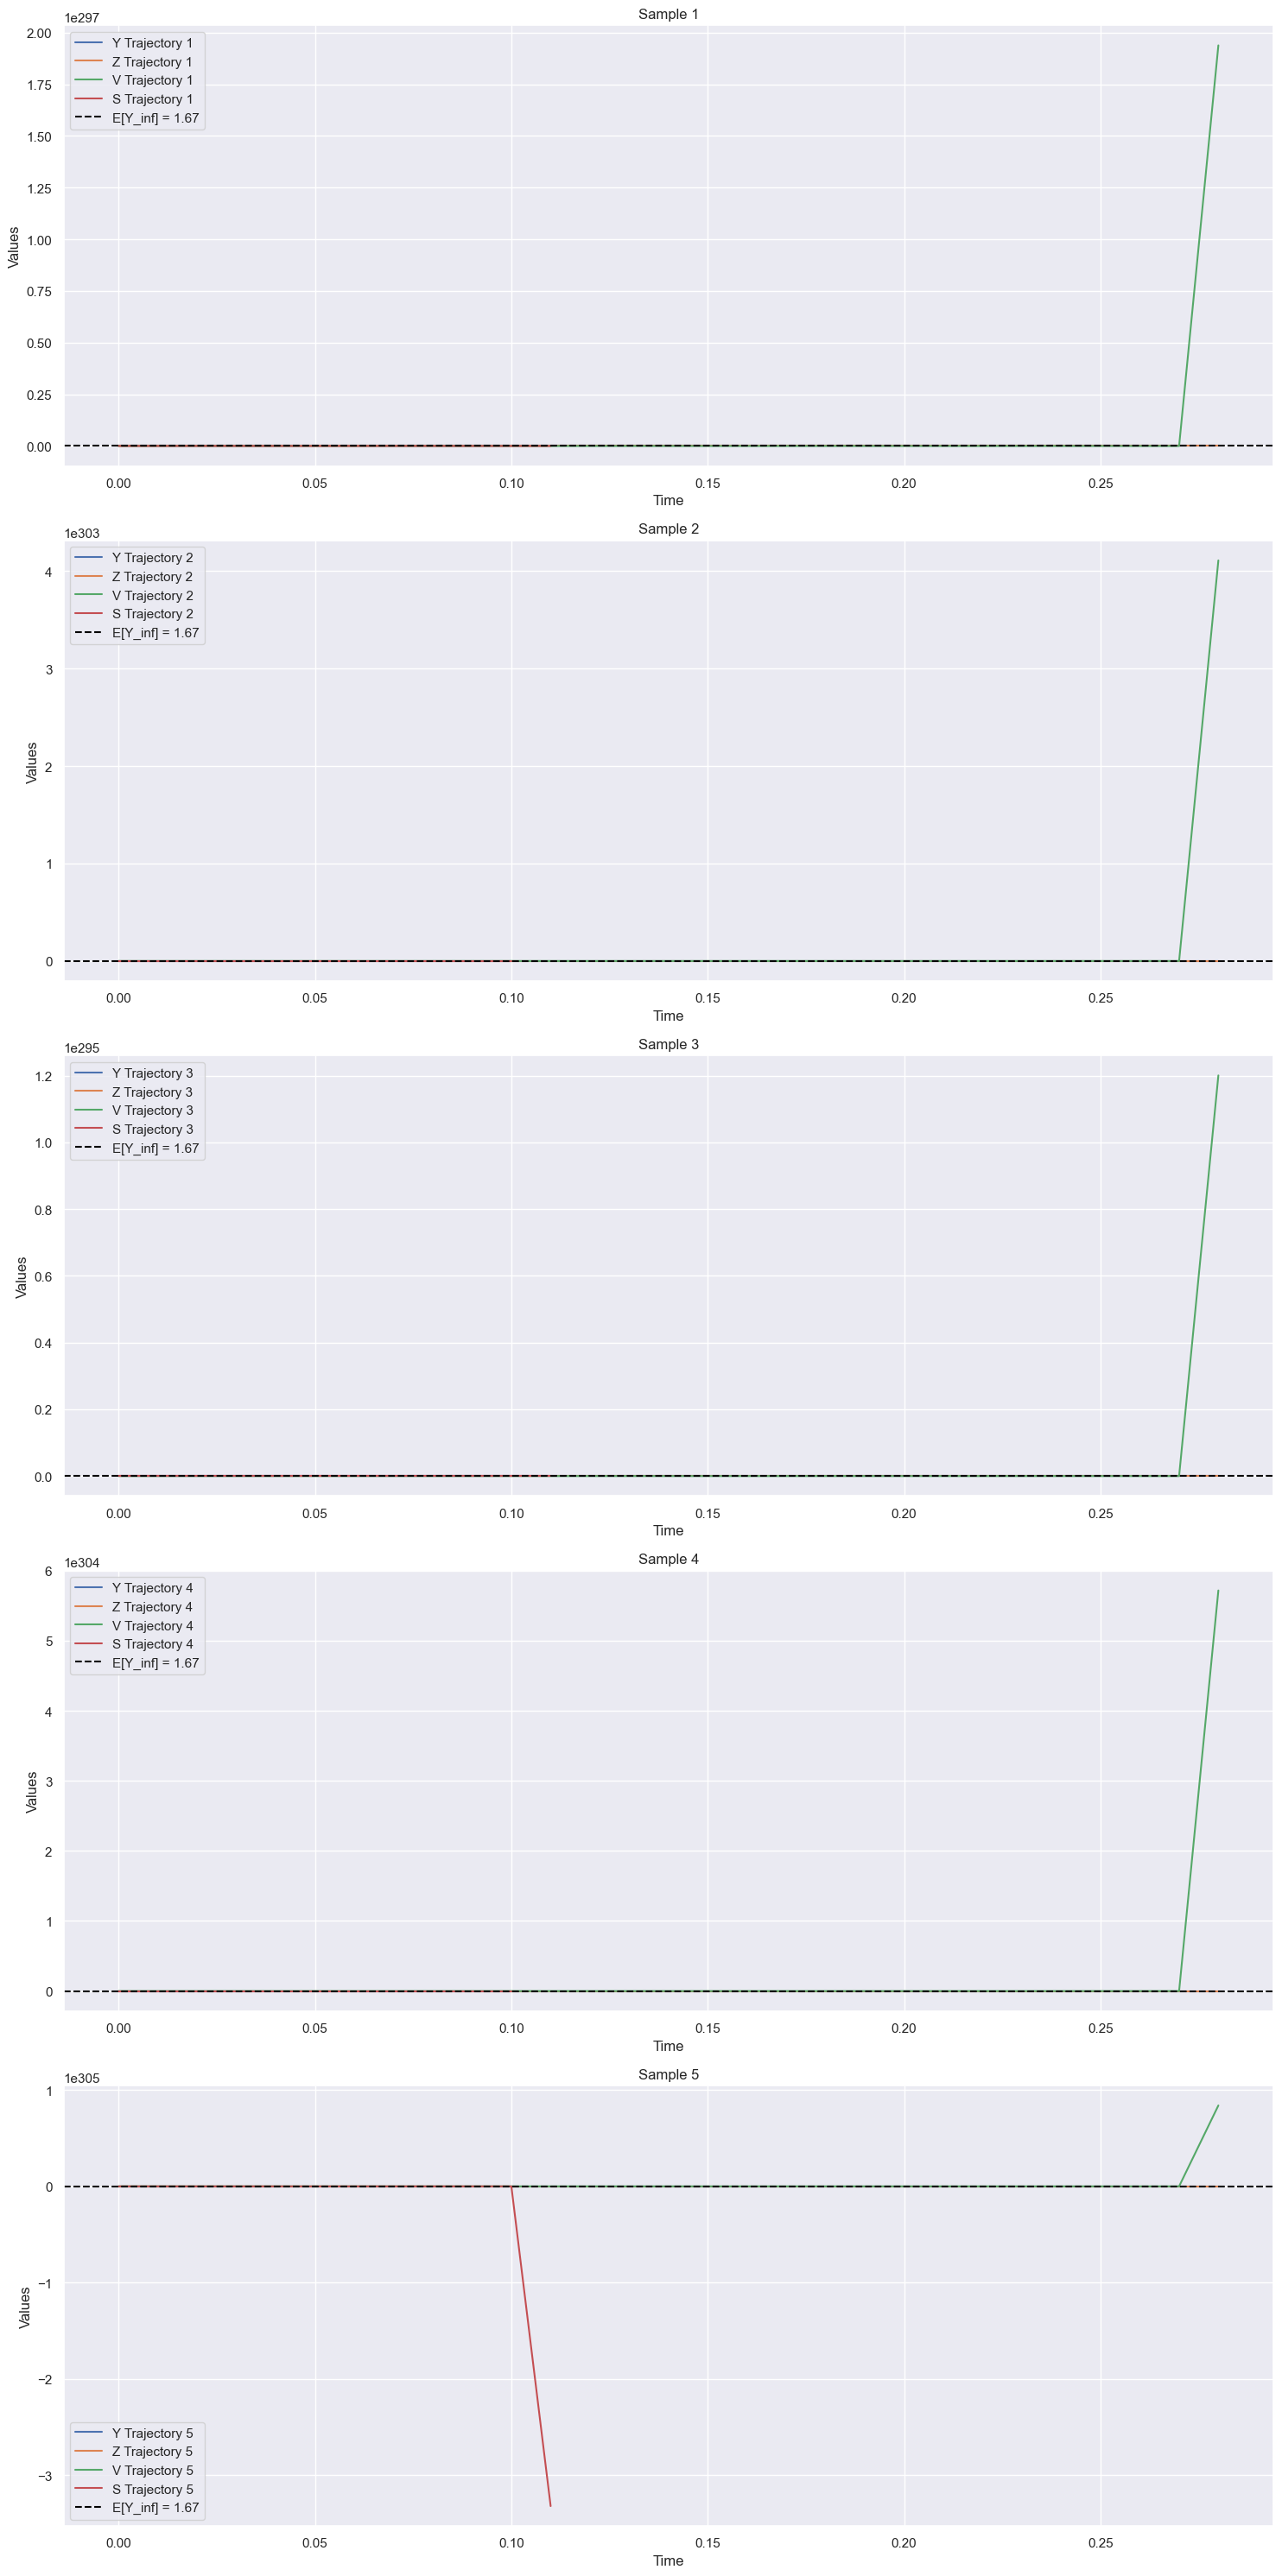

In [16]:
N = 500
times = np.linspace(start=0, stop=T, num=N+1)  # Discrétisation de [0, T] en N+1 points, pas de T/N
# Première simulation
eta = 0.1

# Paramètres de la fonction b
mu = 2
lamb = 1.2

# Processus markovien poisson rouge Y
xi0 = 0

Y, Z, V, S = simulate_model_v2(s0, eta, mu, lamb, a, b, c, H, T, xi0, N, size_sample, rho)

plt.figure(figsize=(15, 6 * size_sample))
for i in range(size_sample):
    plt.subplot(size_sample, 1, i + 1)
    plt.plot(times, Y[:, i], label=f"Y Trajectory {i+1}")
    plt.plot(times, Z[:, i], label=f"Z Trajectory {i+1}")
    plt.plot(times, V[:, i], label=f"V Trajectory {i+1}")
    plt.plot(times, S[:, i], label=f"S Trajectory {i+1}")
    plt.axhline(y=mu/lamb, color="black", linestyle="--", label=f"E[Y_inf] = {mu/lamb:.2f}")
    plt.title(f"Sample {i+1}")
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.legend()

plt.tight_layout()
plt.show()

### Optimisation de l'implémentation

Dans le but de pousser les recherches, il sera parfois nécessaire de simuler de nombreuses trajectoires indépendantes des processus étudiés. Nous utilisons alors à notre avantage l'indépendance pour distribuer les calculs à travers tous les coeurs du processeur de la machine support.

**Remarques :**
Après plusieurs tentatives d'implémentation via les librairies classiques threading et multiprocessing, il est apparu que les vitesses d'execution des calculs dans les nouveaux threads créés étaient bien inférieurs à la vitesse observée dans le thread principal. Cela est certainement dû à un conflit entre les librairies numpy et multiprocessing. Plutôt que de chercher à résoudre ce conflit, cela me donne une bonne occasion de ré-implémenter l'algorithme en C++ (toujours avec une approche orientée multiprocessing) pour profiter de meilleures performances.

L'implémentation ci-dessous est donc laissée à titre de base de travail mais **ne devrait pas** être utilisée.

In [ ]:
def build_G(var_tuple):
    """
    Construit la matrice G utilisée pour simuler les processus stochastiques.

    Pour des raisons techniques liées au fonctionnement de la librairie multiprocessing (chaque processus admet son propre contexte d'execution), 
    il est nécessaire de construire une fonction avec un unique paramètre.

    :param N: int
        Nombre de points de discrétisation dans le temps.
        
    :param dt: float
        Pas de temps, T/N où T est le temps total de simulation.
        
    :param H: float
        Paramètre de Hurst dans le processus.
        
    :param L_B_int: np.ndarray
        Matrice obtenue après la décomposition de Cholesky de la matrice B_int.
        
    :param V: np.ndarray
        Vecteur V utilisé dans la simulation.
        
    :param U: np.ndarray
        Vecteur U utilisé dans la simulation.
        
    :param K: np.ndarray
        Matrice utilisée dans la décomposition de Cholesky de la matrice de covariance globale.

    :param rng: numpy.random._generator.Generator
        Générateur de nombres pseudo aléatoires numpy.
    
    :return: np.ndarray
        Matrice G utilisée pour simuler les processus stochastiques.
    """
    N = var_tuple[0]
    dt = var_tuple[1]
    H = var_tuple[2]
    L_B_int = var_tuple[3]
    V = var_tuple[4]
    U = var_tuple[5]
    K = var_tuple[6]
    rng = var_tuple[7]
    
    G_traj = np.zeros((N+2, N))
    with tqdm(range(1, N+1), "Calcul de G") as l_range:
        for l in l_range:
            # Décomposition de Cholesky de la sous matrice B_l
            L_B_int_l = L_B_int[:N-l+1, :N-l+1]
            L_B_l = np.power(dt, H) * L_B_int_l
        
            # Sous vecteur V_l
            V_l = V[:N-l+1]
            V_l = V_l.reshape(N-l+1, 1)
        
            # Sous vecteur U_l
            U_l = U[:N-l+1]
            U_l = U_l.reshape(N-l+1, 1)
        
            # Sous matrice
            s_l = np.hstack((V_l, U_l))
        
            # Décomposition de Cholesky de la matrice de covariance globale Sigma_l
            delta_l = np.linalg.solve(L_B_l, s_l)
        
            Temp = K - np.transpose(delta_l) @ delta_l
            # On s'assure que la matrice B_int est semi définie positive en gommant les erreur numériques
            Temp = Temp + (10e-9) * np.eye(2)
            try:
                M = np.linalg.cholesky(Temp)
            except np.linalg.LinAlgError as e:
                print("Erreur lors du calcul de la décomposition de Cholesky de la matrice K - (delta_l)^T * delta_l :", str(e))
                raise ValueError  # Ne devrait pas arriver, la matrice est semie définie positive...
                
            # Initialisation de la matrice L_l
            L_l = np.zeros((N-l+3, N-l+3))
            L_l[:N-l+1, :N-l+1] = L_B_l
            
            # Ajout de delta_l dans L_l
            delta_l_t = np.transpose(delta_l)
            L_l[N-l+1:N-l+3, :N-l+1] = delta_l_t
            
            # Ajout de M dans L_l
            L_l[N-l+1:N-l+3, N-l+1:N-l+3] = M
        
            # Accroissements browniens
            w_acc = rng.standard_normal(size=(N-l+3, 1))
            
            # l-ième colonne de G simulée
            G_traj[l-1:N+2, l-1] = (L_l @ w_acc)[:, 0]

    return G_traj

In [ ]:
def simulate_model_mp(s0, eta, mu, lamb, a, b, c, H, T, xi0, N, size_sample, rho, rng, nb_processes=0):
    """
    Simule les trajectoires d'un actif financier selon le modèle présenté dans l'article. 
    Ce modèle est particulier dans le sens où la volatilité de l'actif possède un effet de mémoire. 

    :param s0: Float
        Prix initial de l'actif financier.

    :param eta: Float
        Facteur d'échelle pour lisser la volatilité des processus "poisson rouge" et "éléphant".

    :param mu: Float
        Taux de rendement moyen attendu de l'actif.

    :param lamb: Float
        Taux de retour à la moyenne pour le modèle de "poisson rouge".

    :param a: Float
        Coefficient de l'échelle de la variance dans le modèle de l'actif.

    :param b: Float
        Point moyen autour duquel la variance fluctue.

    :param c: Float
        Terme constant ajouté à la variance. Seuil minimal / Variance "planchée"

    :param H: Float
        Paramètre de Hurst, contrôlant le degré de mémoire du processus "éléphant".

    :param T: Float
        Durée totale de la période de simulation, en années.

    :param xi0: Float
        Condition initiale pour le processus "éléphant".

    :param N: Int
        N+1 points de temps pour un pas de T/N.

    :param size_sample: Int
        Nombre de trajectoires indépendantes à simuler.

    :param rho: Float
        Taux de corrélation entre les mouvements browniens guidant les processus modélisant l'actif financier et la volatilité.

    :param rng: numpy.random._generator.Generator
        Générateur de nombres pseudo aléatoires numpy.
        
    :param nb_processes: Int
        Nombre de processus créés pour dispatcher les calculs des trajectoires. Valeur par défaut = nombre de coeurs renvoyés par os.cpu_count().

    :return: tuple of np.arrays
        Renvoie quatre matrices N+1 x size_sample pour Y, Z, V, et S représentant respectivement :
        - Y : le processus 'poisson rouge' markovien
        - Z : le processus 'éléphant' non-markovien
        - V : la variance du processus
        - S : le prix de l'actif financier simulé
    """
    dt = T/N

    if (nb_processes <= 0) or (nb_processes > os.cpu_count()):
        nb_processes = os.cpu_count()

    # -------- Construction de la matrice G pour la simulation des processus --------
    # Calcul de la matrice [B_int]1<=i,j<=N
    B_int = np.zeros((N, N))
    
    # Remplissage de la moitié supérieure (diagonale incluse)
    with tqdm(range(N), desc="Calcul de la matrice B_int") as Nrange:
        for i in Nrange:
            for j in range(i, N):
                B_int[i, j] = b_ij(i, j, H - 1/2)
    
    B_int = B_int + B_int.T - np.diag(np.diag(B_int))

    # On s'assure que la matrice B_int est semi définie positive en gommant les erreur numériques
    B_int = B_int + (10e-9) * np.eye(N)

    print("Décomposition de Cholesky de la matrice B_int")
    # Decomposition de Cholesky de la matrice B_int
    try:
        L_B_int = np.linalg.cholesky(B_int)
    except np.linalg.LinAlgError as e:
        print("Erreur lors du calcul de la décomposition de Cholesky de la matrice B_int:", str(e))
        raise ValueError  # Ne devrait pas arriver, la matrice est semie définie positive...

    # Calcul du vecteur V
    t = np.arange(N)
    V = np.power(T/N, H + 1/2) * (1 / (H + 1/2)) * ((t + 1)**(H + 1/2) - t**(H + 1/2))

    # Calcul du vecteur U
    U = rho * V

    # Calcul de la matrice K
    K = np.array([[T/N, rho * T/N], 
                  [rho * T/N, T/N]])   

    # -------- Construction des N colonnes de G --------
    list_G = []  # Une matrice G par trajectoire
    streams = rng.spawn(size_sample)
    var_tuple_list = [tuple((N, dt, H, L_B_int, V, U, K, rng_traj)) for rng_traj in streams]
    with Pool(processes=nb_processes) as pool:
        list_G = pool.map(build_G, var_tuple_list)
            
    # -------- Simulation des processus --------
    Y = np.zeros(shape=(N+1, size_sample))  # Le processus commence en 0, donc N browniens pour une trajectoire de N+1 points
    Z = np.zeros(shape=(N+1, size_sample))
    Z[0, :] = xi0
    V = np.zeros(shape=(N+1, size_sample))
    V[0, :] = a*(xi0 - b)**2 + c
    S = np.zeros(shape=(N+1, size_sample))
    S[0, :] = s0
    with tqdm(range(1, N+1), desc="Simulation des trajectoires") as Nrange:
        for n in Nrange:
            for num_traj in range(size_sample):
                G_traj = list_G[num_traj]

                # Simulation du processus markovien "poisson rouge"
                Y[n][num_traj] = Y[n-1][num_traj] + xi0*(1/gamma_function(3/2 - H))*(np.power(n*dt, 1/2 - H) - np.power((n-1)*dt, 1/2 - H)) + dt*b_func(Y[n-1][num_traj], mu, lamb) + eta*sigma(Y[n-1][num_traj], a, b, c)* G_traj[N, n-1]
                # print(f"G_traj[{N}, {n}-1] : {G_traj[N, n-1]}")
                
                # Simulation du processus "elephant"
                Z[n][num_traj] = xi0
        
                # Calcul de la somme
                l = np.arange(n)
    
                # Premier terme déterministe
                vectorized_deterministic_term = np.vectorize(lambda v1, v2: deterministic_term(v1, v2, n, mu, lamb, H, dt))
                xi = Y[:n, num_traj]
                s1 = vectorized_deterministic_term(l, xi)
    
                # Second terme stochastique
                s2 = eta * sigma(xi, a, b, c) * G_traj[n-1, :n]
                
                Z[n][num_traj] += np.sum(s1 +s2)*(1 / gamma_function(H + 1/2))
                # print(f"num_traj = {num_traj}\nn = {n}\nxi = {xi}\nG_traj[n-1, :n] = {G_traj[n-1, :n]}\n")

                # Simulation du processus de Variance
                V[n][num_traj] = a*np.power(Z[n][num_traj] - b, 2) + c
    
                # Simulation de l'actif financier
                S[n][num_traj] = S[n-1][num_traj] + S[n-1][num_traj]*np.sqrt(V[n-1][num_traj])*G_traj[N+1, n-1]
                # print(f"G_traj[{N+1}, {n}-1] : {G_traj[N+1, n-1]}")

    
    return Y, Z, V, S

In [ ]:
# Paramètres de la simulation
# Globaux
s0 = 1           # Prix initial de l'actif
T = 5            # Maturité / Temps d'arrêt de la simulation
N = 100         # N+1 points de discrétisations de l'intervalle [0, T]
size_sample = 5  # Nombre de trajectoires à générer

H = 0.1  # Paramètre de Hurst

# Paramètres de la fonction sigma
a = 0.384
b = 0.095
c = 0.0025

# Taux de corrélation des browniens
rho = -0.7

times = np.linspace(start=0, stop=T, num=N+1)  # Discrétisation de [0, T] en N+1 points, pas de T/N

# Première simulation
eta = 0.1

# Paramètres de la fonction b
mu = 2
lamb = 1.2

# Processus markovien poisson rouge Y
xi0 = 0

Y, Z, V, S = simulate_model_mp(s0, eta, mu, lamb, a, b, c, H, T, xi0, N, size_sample, rho, rng)

plt.figure(figsize=(15, 6 * size_sample))
for i in range(size_sample):
    plt.subplot(size_sample, 1, i + 1)
    plt.plot(times, Y[:, i], label=f"Y Trajectory {i+1}")
    plt.plot(times, Z[:, i], label=f"Z Trajectory {i+1}")
    plt.plot(times, V[:, i], label=f"V Trajectory {i+1}")
    plt.plot(times, S[:, i], label=f"S Trajectory {i+1}")
    plt.axhline(y=mu/lamb, color="black", linestyle="--", label=f"E[Y_inf] = {mu/lamb:.2f}")
    plt.title(f"Sample {i+1}")
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.legend()

plt.tight_layout()
plt.show()